EE5179 : Deep Learning for Imaging

Programming Assignment 3: Autoencoders

Name: SRIVATSAN SARVESAN

Roll No: DA24E001

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch import nn

In [3]:
#HYPERPARAMETERS
learning_rate=0.001
epochs=10
batch_size= 256
number_of_pc=30 #number of principal components (for PCA)

In [4]:
train_data = torchvision.datasets.MNIST(root="./",train=True,transform=transforms.ToTensor(),download=True)
test_data = torchvision.datasets.MNIST(root="./",train=False,transform=transforms.ToTensor(),download=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.2MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 351kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.77MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.18MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=len(test_data),shuffle=False)

In [6]:
test_sample_loader = torch.utils.data.DataLoader(dataset=test_data.data[9705:9715],shuffle=False,batch_size=10)

In [7]:
train_dataset=train_data.data.reshape(train_data.data.shape[0],train_data.data.shape[1]*train_data.data.shape[2])
test_dataset = test_data.data.reshape(test_data.data.shape[0],test_data.data.shape[1]*test_data.data.shape[2])
test_dataset_sampled= test_dataset[np.arange(9705,9715),:]



```
# This is formatted as code
```

#**Comparing PCA and Autoencoders**

In [ ]:
def PCA(input_data,top_k_ev):
  '''
  function: This function performs pca.
  Input: input_data = (torch matrix) = of shape num_datapts,784pixels
          top_k_ev = (integer) = how many principal components to be taken

  Output: top_k_eigen_vectors= shape(784,top_k_ev) top k eigen vectors in columns
          centered_ip_data= shape(num_datapts,784) = centered ip data (used for reconstruction from principal components)

  '''

  input_mean = torch.mean(input_data,0)
  centered_ip_data = input_data-input_mean
  cov_matrix = torch.matmul(centered_ip_data.T,centered_ip_data)
  eigen_values, eigen_vectors = torch.linalg.eigh(cov_matrix)
  eigen_values_descending,indices = torch.sort(eigen_values,descending=True)
  top_k_eigen_values,top_k_indices = eigen_values_descending[:top_k_ev],indices[:top_k_ev]
  top_k_eigen_vectors = eigen_vectors[:,top_k_indices]


  assert top_k_eigen_vectors.shape == (784,top_k_ev)
  assert centered_ip_data.shape == input_data.shape
  assert input_mean.shape == torch.Size([784])

  return top_k_eigen_vectors

In [ ]:
pc=PCA(train_dataset.float(),number_of_pc)

In [ ]:
def reconstruct_data(principal_components,dataset):
  '''
  function: This function reconstructs the datapoints in lower dimension (i.e. top k eigen_vector components).

  Input: principal_components= shape(784,top_k_ev) top k eigen vectors in columns
          centered_ip_data= shape(num_datapts,784) = centered ip data (used for reconstruction from principal components)

  Output: projected_data = (torch matrix) = of shape num_datapts , top_k_ev

  '''
  projection_matrix = torch.matmul(principal_components,principal_components.T)
  projected_data = torch.matmul(dataset,projection_matrix)

  assert projected_data.shape == (dataset.shape[0],principal_components.shape[0])

  return projected_data

In [ ]:
reconstructed_test_data_sampled=reconstruct_data(pc,test_dataset_sampled.float())

In [ ]:
class AE1(nn.Module):
  def __init__(self):
    super(AE1, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,30),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(30,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,784),
        nn.ReLU())

  def forward(self,x):
    x=self.encoder(x)
    encoded_output=x
    x=self.decoder(x)
    return x,encoded_output

In [ ]:
model1 = AE1()
criterion1 = nn.MSELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

training_loss = []

epochs = 10
for epoch in range(epochs):
    epoch_loss = 0  # To accumulate loss over the entire epoch
    for images, labels in train_loader:
        images = images.reshape(images.shape[0], -1)  # Flatten the images
        outputs, _ = model1(images)
        loss = criterion1(outputs, images)  # Calculate the loss

        training_loss.append(loss.item())  # Record the loss
        epoch_loss += loss.item()  # Accumulate loss for the epoch

        optimizer1.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer1.step()  # Update the weights

    avg_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")  # Print the loss


Epoch [1/10], Loss: 0.0584
Epoch [2/10], Loss: 0.0321
Epoch [3/10], Loss: 0.0266
Epoch [4/10], Loss: 0.0237
Epoch [5/10], Loss: 0.0220
Epoch [6/10], Loss: 0.0208
Epoch [7/10], Loss: 0.0197
Epoch [8/10], Loss: 0.0189
Epoch [9/10], Loss: 0.0178
Epoch [10/10], Loss: 0.0173


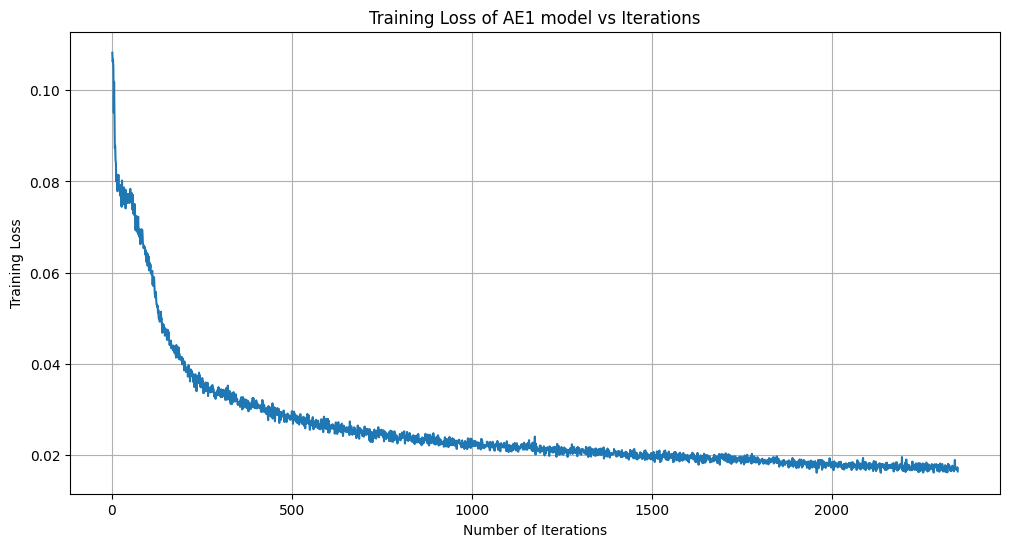

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1,len(training_loss)+1),training_loss)
plt.title("Training Loss of AE1 model vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.grid()

_______________________________________________________________________________________
Reconstruction Error in AE: 6.307659293984471
Reconstruction Error in PCA: 4.906910216143052


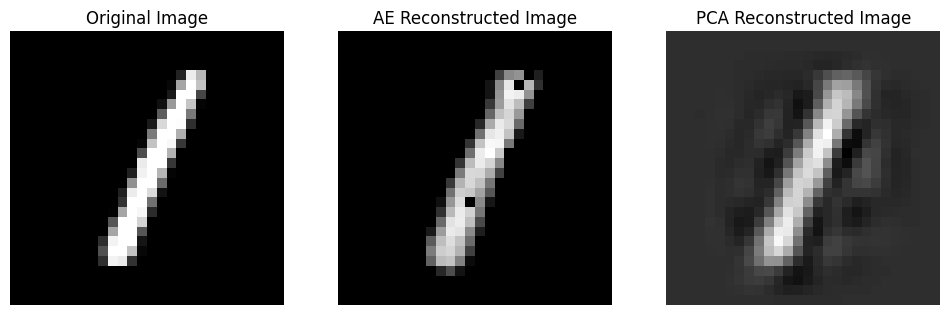

_______________________________________________________________________________________
Reconstruction Error in AE: 21.927312816323273
Reconstruction Error in PCA: 16.862376030476067


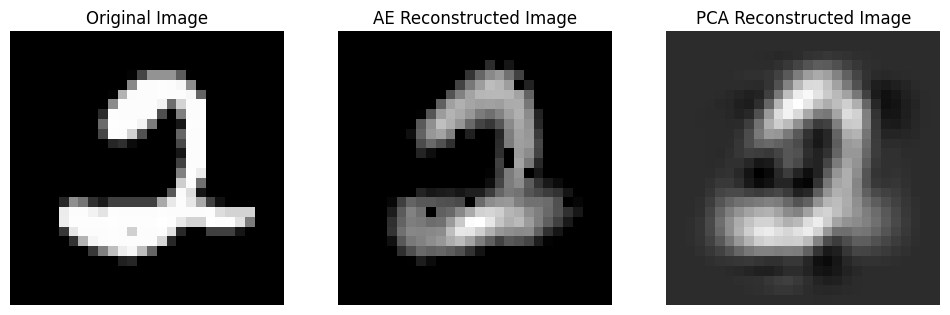

_______________________________________________________________________________________
Reconstruction Error in AE: 20.272061440857204
Reconstruction Error in PCA: 16.0457551172948


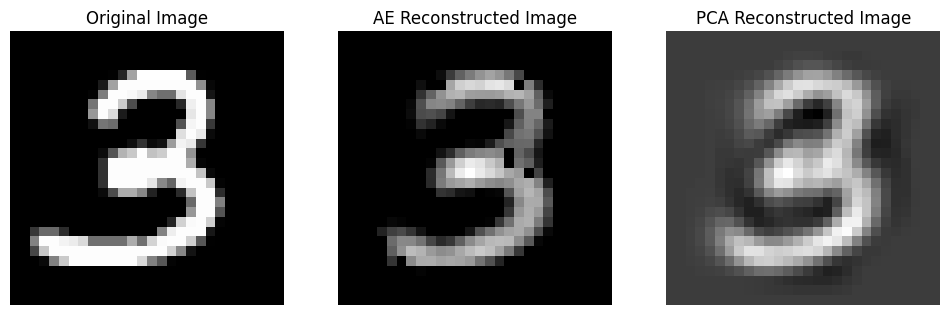

_______________________________________________________________________________________
Reconstruction Error in AE: 13.899205078610088
Reconstruction Error in PCA: 10.714796514097081


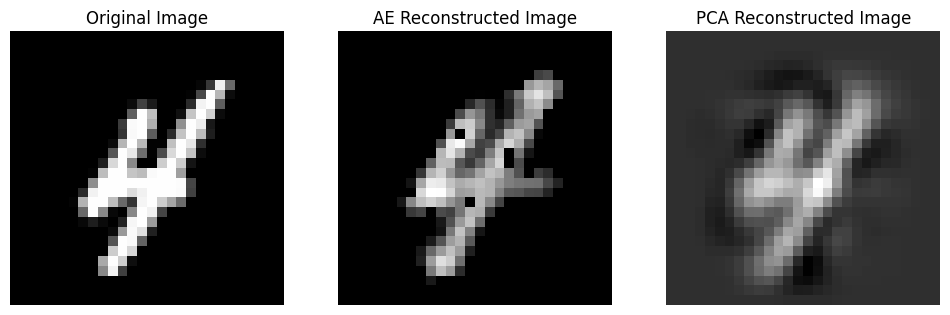

_______________________________________________________________________________________
Reconstruction Error in AE: 12.313258415085311
Reconstruction Error in PCA: 14.848193155147694


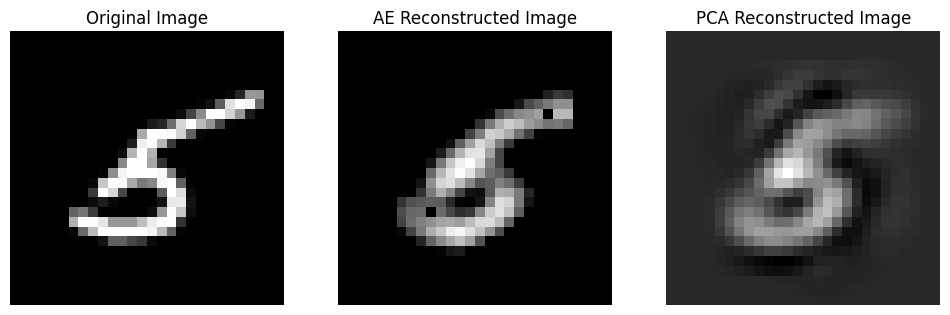

_______________________________________________________________________________________
Reconstruction Error in AE: 25.932653129596723
Reconstruction Error in PCA: 20.39081935165547


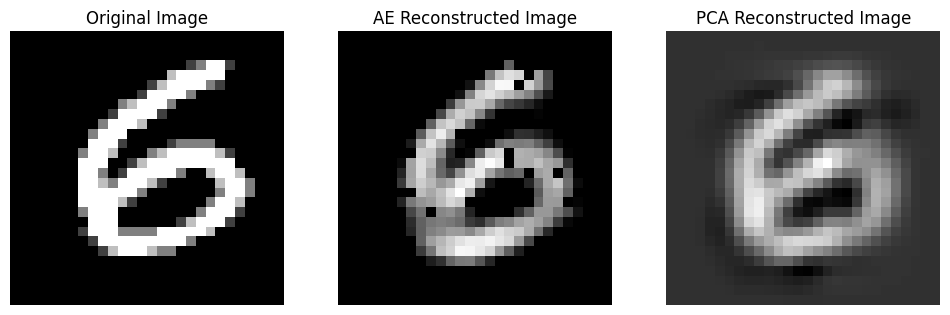

_______________________________________________________________________________________
Reconstruction Error in AE: 15.285770999594304
Reconstruction Error in PCA: 11.735863218712451


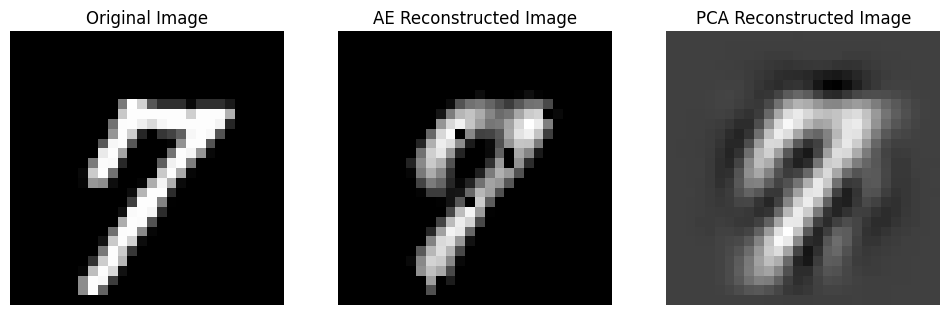

_______________________________________________________________________________________
Reconstruction Error in AE: 13.924664436835346
Reconstruction Error in PCA: 14.356571254531701


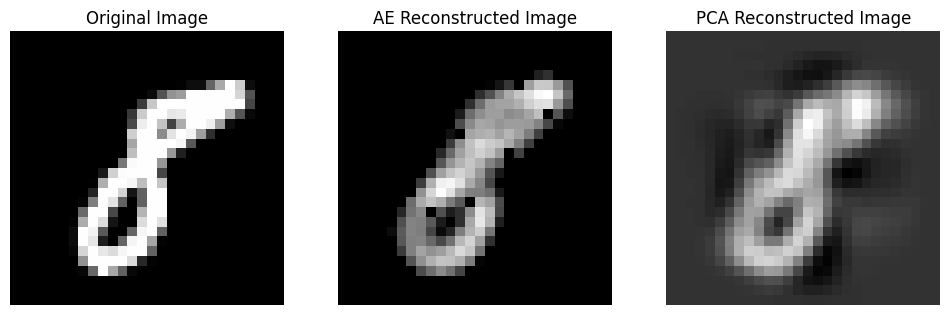

_______________________________________________________________________________________
Reconstruction Error in AE: 14.230142970600042
Reconstruction Error in PCA: 13.215490057306457


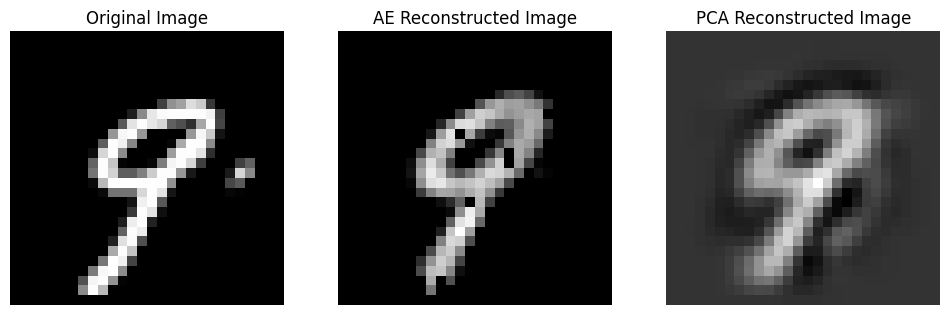

_______________________________________________________________________________________
Reconstruction Error in AE: 18.62658867292707
Reconstruction Error in PCA: 16.605797151615285


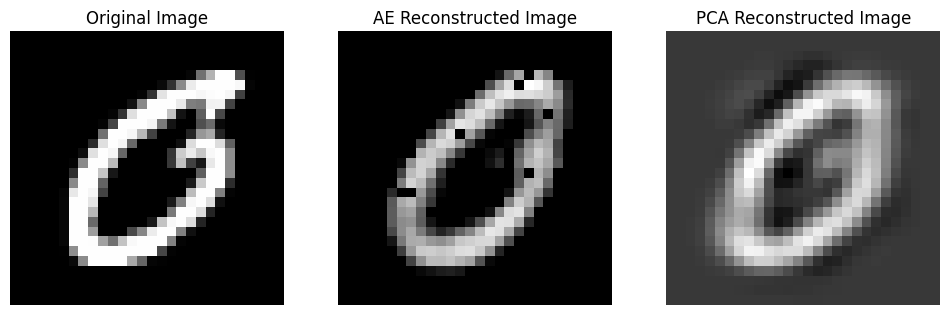

In [ ]:
#MODEL EVALUATION AND RESULT PLOTTING
model1.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs,_ = model1(images.float())

plt.rcParams["figure.figsize"] = (12,6)
for i in range (10):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('AE Reconstructed Image')
  ax2.axis("off")

  ax3.imshow(reconstructed_test_data_sampled[i].reshape(28,28),cmap='gray')
  ax3.set_title('PCA Reconstructed Image')
  ax3.axis("off")
  print("_______________________________________________________________________________________")
  print("Reconstruction Error in AE:",np.dot(((images[i].detach().numpy()/255)-(outputs[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs[i].detach().numpy()/255)).T))
  print("Reconstruction Error in PCA:",np.dot(((images[i].detach().numpy()/255)-(reconstructed_test_data_sampled[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(reconstructed_test_data_sampled[i].detach().numpy()/255)).T))
  plt.show()

In [ ]:
epochs=20

model2 = AE1()
criterion1 = nn.MSELoss()
optimizer1 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

training_loss = []

for epoch in range(epochs):
    epoch_loss = 0  # To accumulate loss over the entire epoch
    for images, labels in train_loader:
        images = images.reshape(images.shape[0], -1)  # Flatten the images
        outputs, _ = model2(images)
        loss = criterion1(outputs, images)  # Calculate the loss

        training_loss.append(loss.item())  # Record the loss
        epoch_loss += loss.item()  # Accumulate loss for the epoch

        optimizer1.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer1.step()  # Update the weights

    avg_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")  # Print the loss


Epoch [1/20], Loss: 0.0623
Epoch [2/20], Loss: 0.0339
Epoch [3/20], Loss: 0.0277
Epoch [4/20], Loss: 0.0246
Epoch [5/20], Loss: 0.0229
Epoch [6/20], Loss: 0.0214
Epoch [7/20], Loss: 0.0203
Epoch [8/20], Loss: 0.0193
Epoch [9/20], Loss: 0.0187
Epoch [10/20], Loss: 0.0182
Epoch [11/20], Loss: 0.0177
Epoch [12/20], Loss: 0.0173
Epoch [13/20], Loss: 0.0169
Epoch [14/20], Loss: 0.0166
Epoch [15/20], Loss: 0.0161
Epoch [16/20], Loss: 0.0159
Epoch [17/20], Loss: 0.0157
Epoch [18/20], Loss: 0.0156
Epoch [19/20], Loss: 0.0154
Epoch [20/20], Loss: 0.0153


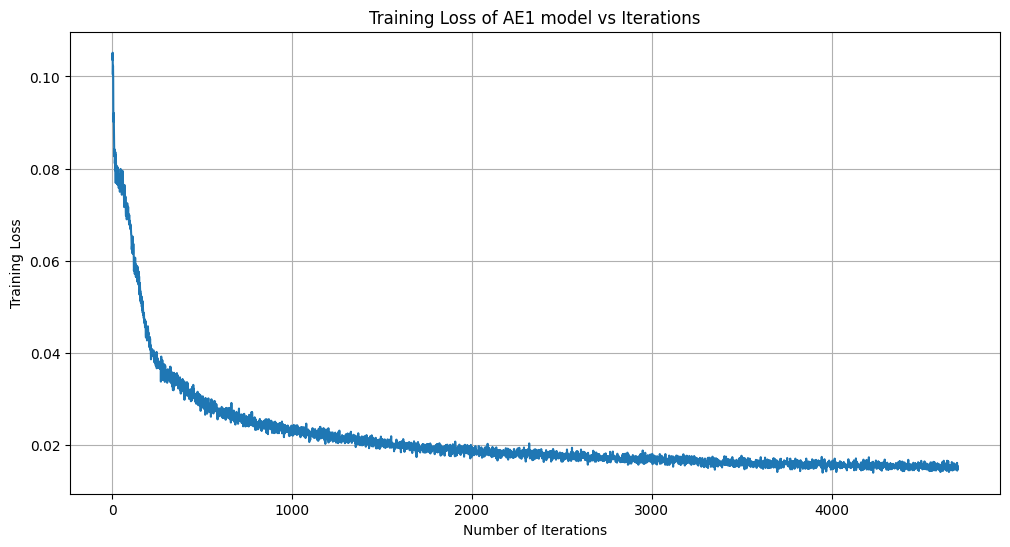

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1,len(training_loss)+1),training_loss)
plt.title("Training Loss of AE1 model vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.grid()

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 6.307659293984471
Reconstruction Error in AE(epochs=20): 7.2013589254356365
Reconstruction Error in PCA: 4.906910216143052


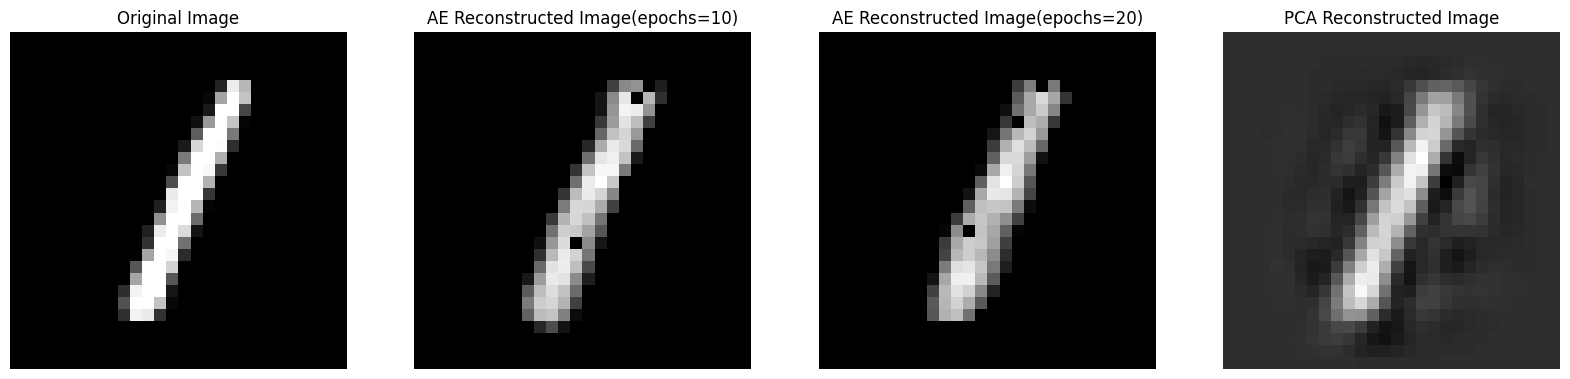

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 21.927312816323273
Reconstruction Error in AE(epochs=20): 30.92957060781849
Reconstruction Error in PCA: 16.862376030476067


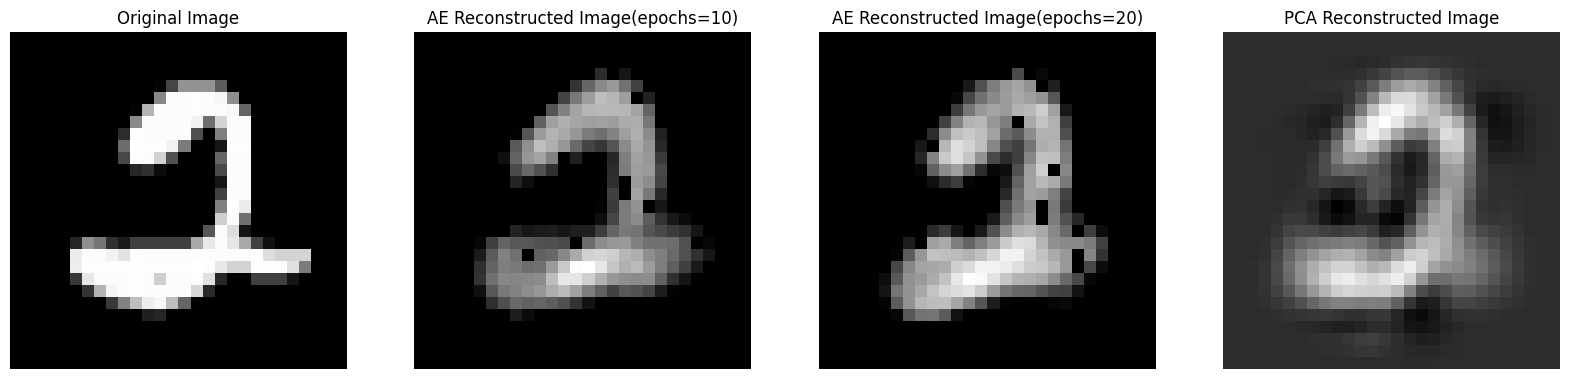

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 20.272061440857204
Reconstruction Error in AE(epochs=20): 15.765950224609877
Reconstruction Error in PCA: 16.0457551172948


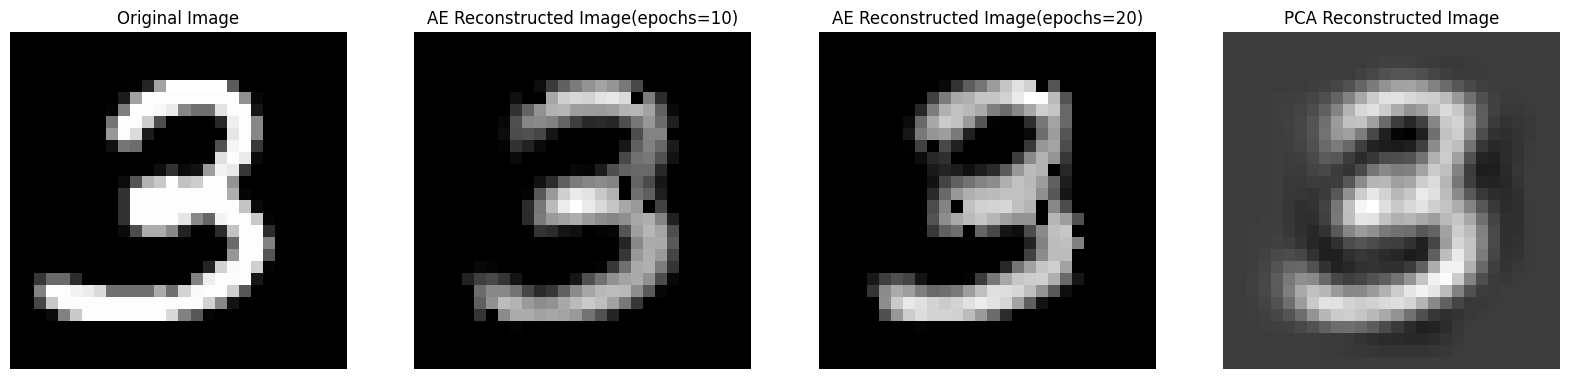

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 13.899205078610088
Reconstruction Error in AE(epochs=20): 12.61424778484006
Reconstruction Error in PCA: 10.714796514097081


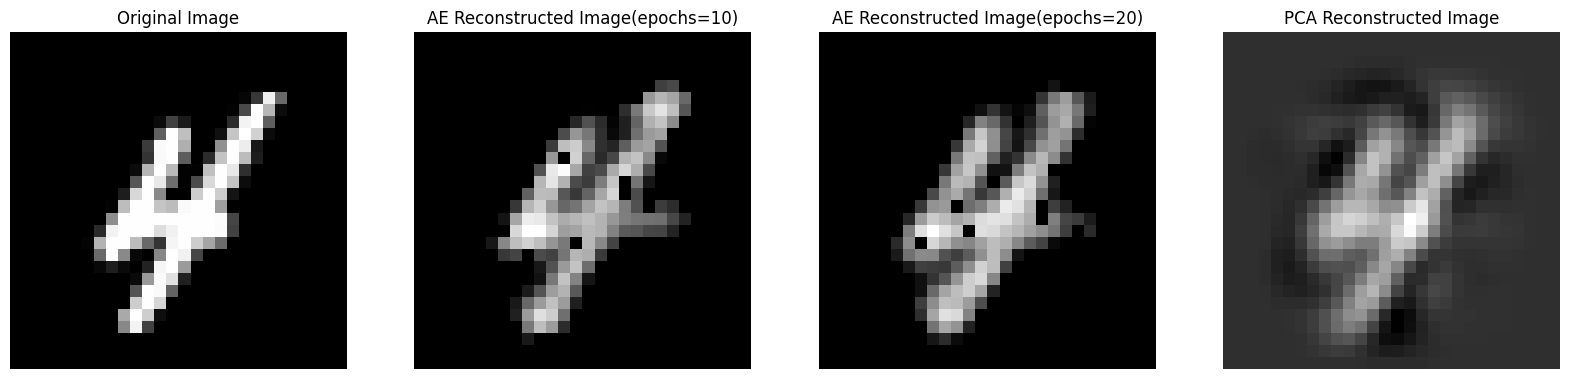

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 12.313258415085311
Reconstruction Error in AE(epochs=20): 12.80333184312766
Reconstruction Error in PCA: 14.848193155147694


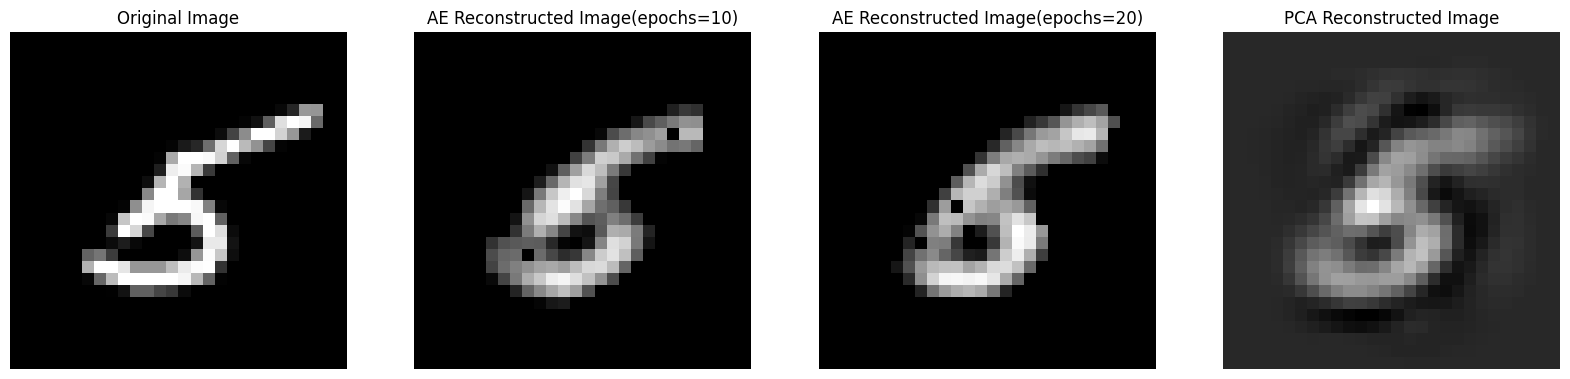

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 25.932653129596723
Reconstruction Error in AE(epochs=20): 27.042785428365406
Reconstruction Error in PCA: 20.39081935165547


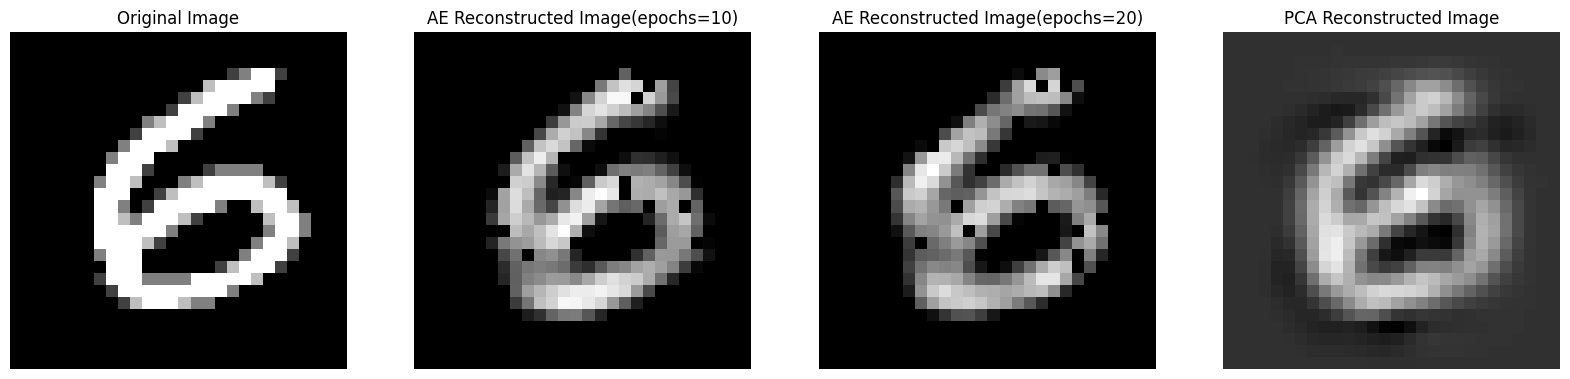

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 15.285770999594304
Reconstruction Error in AE(epochs=20): 13.609016259185033
Reconstruction Error in PCA: 11.735863218712451


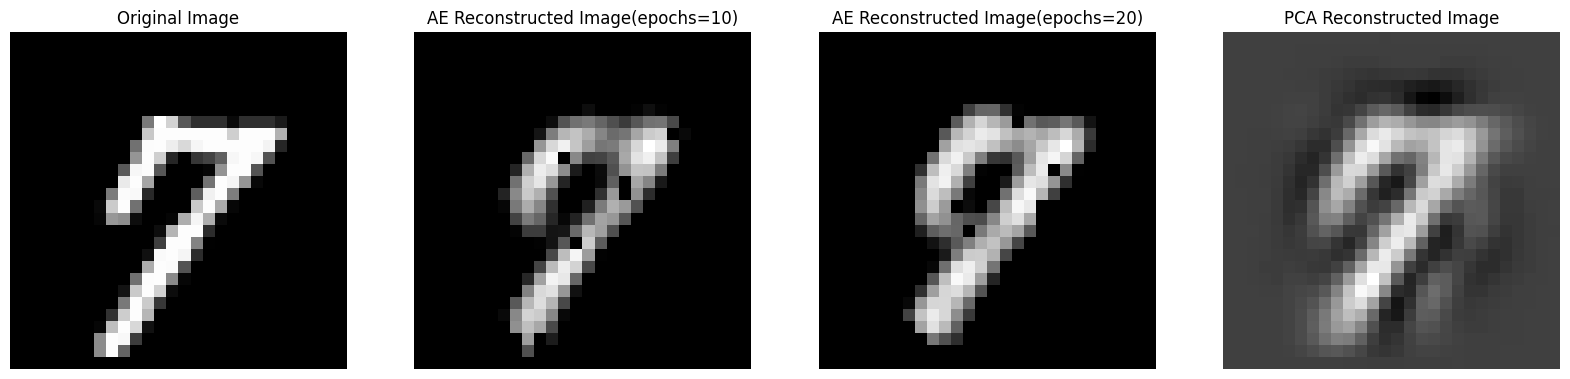

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 13.924664436835346
Reconstruction Error in AE(epochs=20): 15.198742691518415
Reconstruction Error in PCA: 14.356571254531701


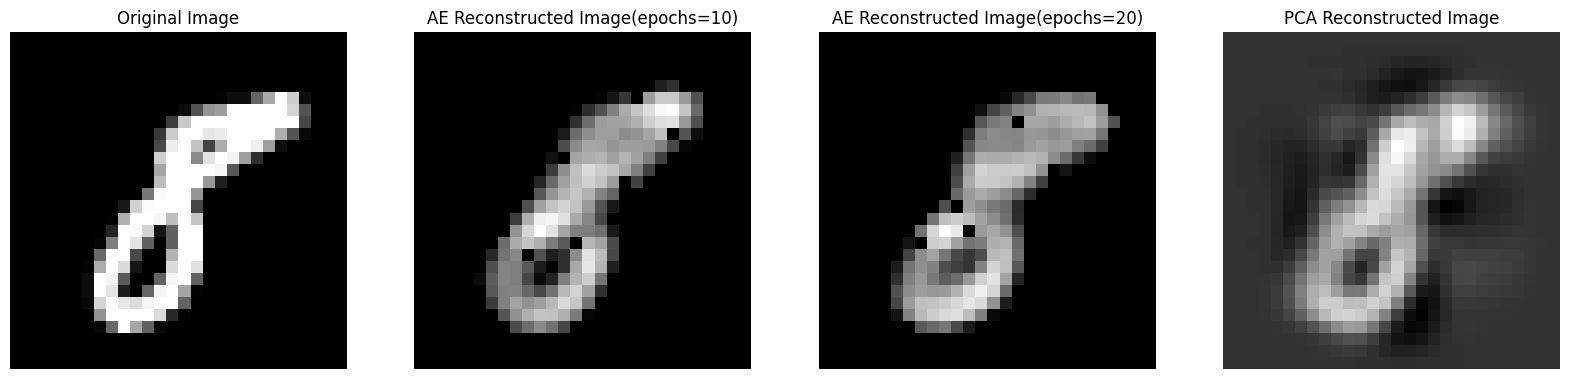

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 14.230142970600042
Reconstruction Error in AE(epochs=20): 14.036274052054509
Reconstruction Error in PCA: 13.215490057306457


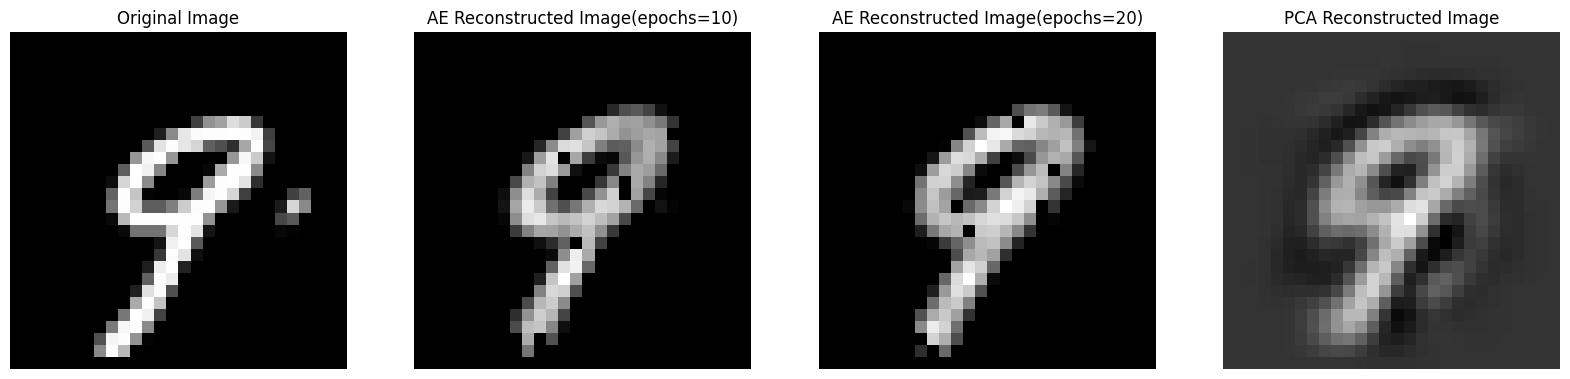

_______________________________________________________________________________________
Reconstruction Error in AE(epochs=10): 18.62658867292707
Reconstruction Error in AE(epochs=20): 20.33213802100416
Reconstruction Error in PCA: 16.605797151615285


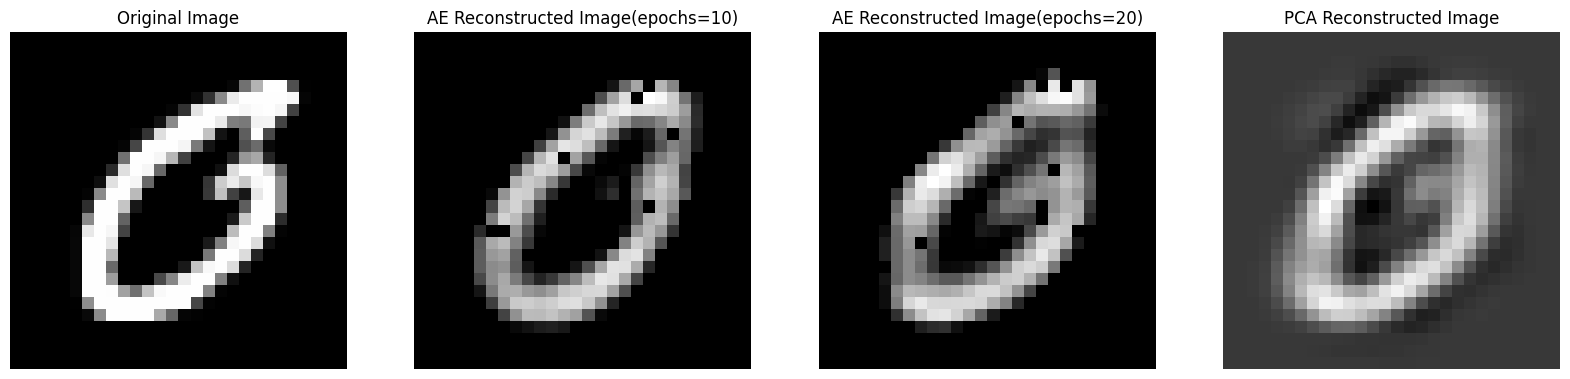

In [ ]:
#MODEL EVALUATION AND RESULT PLOTTING
model1.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_1,_ = model1(images.float())

model2.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_2,_ = model2(images.float())

plt.rcParams["figure.figsize"] = (20,6)
for i in range (10):
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_1[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('AE Reconstructed Image(epochs=10)')
  ax2.axis("off")

  ax3.imshow(outputs_2[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('AE Reconstructed Image(epochs=20)')
  ax3.axis("off")

  ax4.imshow(reconstructed_test_data_sampled[i].reshape(28,28),cmap='gray')
  ax4.set_title('PCA Reconstructed Image')
  ax4.axis("off")
  print("_______________________________________________________________________________________")
  print("Reconstruction Error in AE(epochs=10):",np.dot(((images[i].detach().numpy()/255)-(outputs_1[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_1[i].detach().numpy()/255)).T))
  print("Reconstruction Error in AE(epochs=20):",np.dot(((images[i].detach().numpy()/255)-(outputs_2[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_2[i].detach().numpy()/255)).T))
  print("Reconstruction Error in PCA:",np.dot(((images[i].detach().numpy()/255)-(reconstructed_test_data_sampled[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(reconstructed_test_data_sampled[i].detach().numpy()/255)).T))
  plt.show()

**Observations:**
- Visually, Reconstructed Autoencoder images look appealing as they have better contrast.
- Reconstruction error-wise, Reconstructed PCA images are found to have lesser error (doesnot have much difference though), however they lack the contrast.

#**Standard Autoencoder**

In [ ]:
class AE2(nn.Module):
  def __init__(self,hid):
    super(AE2, self).__init__()
    self.hid=hid
    self.encoder = nn.Sequential(
        nn.Linear(784,self.hid),
        nn.ReLU()
        )
    self.decoder =nn.Sequential(
        nn.Linear(self.hid,784),
        nn.ReLU()
        )

  def forward(self,x):
    x=self.encoder(x)
    encoded_output=x
    x=self.decoder(x)
    return x,encoded_output

In [ ]:
# Model with hidden size = 64
epochs = 10
model_hid64 = AE2(64)
criterion_hid64 = nn.MSELoss()
optimizer_hid64 = torch.optim.Adam(model_hid64.parameters(), lr=learning_rate)

training_loss_hid64 = []

for epoch in range(epochs):
    epoch_loss = 0  # To accumulate the loss over the epoch
    for images, labels in train_loader:
        images = images.reshape(images.shape[0], -1)  # Flatten the images
        outputs, _ = model_hid64(images)
        loss = criterion_hid64(outputs, images)  # Calculate loss

        training_loss_hid64.append(loss.item())  # Record loss for each batch
        epoch_loss += loss.item()  # Accumulate the loss for the epoch

        optimizer_hid64.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate the loss
        optimizer_hid64.step()  # Update the weights

    avg_loss = epoch_loss / len(train_loader)  # Compute average loss for the epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")  # Print average loss for each epoch


Epoch [1/10], Loss: 0.0364
Epoch [2/10], Loss: 0.0164
Epoch [3/10], Loss: 0.0140
Epoch [4/10], Loss: 0.0130
Epoch [5/10], Loss: 0.0124
Epoch [6/10], Loss: 0.0120
Epoch [7/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0117
Epoch [9/10], Loss: 0.0116
Epoch [10/10], Loss: 0.0115


In [ ]:
# Model with hidden size = 128
model_hid128 = AE2(128)
epochs=10
criterion_hid128 = nn.MSELoss()
optimizer_hid128 = torch.optim.Adam(model_hid128.parameters(), lr=learning_rate)

training_loss_hid128 = []

for epoch in range(epochs):
    epoch_loss = 0  # To accumulate the loss over the epoch
    for images, labels in train_loader:
        images = images.reshape(images.shape[0], -1)  # Flatten the images
        outputs, _ = model_hid128(images)
        loss = criterion_hid128(outputs, images)  # Calculate loss

        training_loss_hid128.append(loss.item())  # Record loss for each batch
        epoch_loss += loss.item()  # Accumulate the loss for the epoch

        optimizer_hid128.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate the loss
        optimizer_hid128.step()  # Update the weights

    avg_loss = epoch_loss / len(train_loader)  # Compute average loss for the epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")  # Print average loss for each epoch


Epoch [1/10], Loss: 0.0270
Epoch [2/10], Loss: 0.0110
Epoch [3/10], Loss: 0.0092
Epoch [4/10], Loss: 0.0085
Epoch [5/10], Loss: 0.0081
Epoch [6/10], Loss: 0.0078
Epoch [7/10], Loss: 0.0077
Epoch [8/10], Loss: 0.0076
Epoch [9/10], Loss: 0.0075
Epoch [10/10], Loss: 0.0074


In [ ]:
# Model with hidden size = 256
model_hid256 = AE2(256)
criterion_hid256 = nn.MSELoss()
optimizer_hid256 = torch.optim.Adam(model_hid256.parameters(), lr=learning_rate)
epochs=10
training_loss_hid256 = []

for epoch in range(epochs):
    epoch_loss = 0  # To accumulate the loss over the epoch
    for images, labels in train_loader:
        images = images.reshape(images.shape[0], -1)  # Flatten the images
        outputs, _ = model_hid256(images)
        loss = criterion_hid256(outputs, images)  # Calculate loss

        training_loss_hid256.append(loss.item())  # Record loss for each batch
        epoch_loss += loss.item()  # Accumulate the loss for the epoch

        optimizer_hid256.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate the loss
        optimizer_hid256.step()  # Update the weights

    avg_loss = epoch_loss / len(train_loader)  # Compute average loss for the epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")  # Print average loss for each epoch


Epoch [1/10], Loss: 0.0228
Epoch [2/10], Loss: 0.0099
Epoch [3/10], Loss: 0.0086
Epoch [4/10], Loss: 0.0076
Epoch [5/10], Loss: 0.0071
Epoch [6/10], Loss: 0.0069
Epoch [7/10], Loss: 0.0067
Epoch [8/10], Loss: 0.0066
Epoch [9/10], Loss: 0.0065
Epoch [10/10], Loss: 0.0064


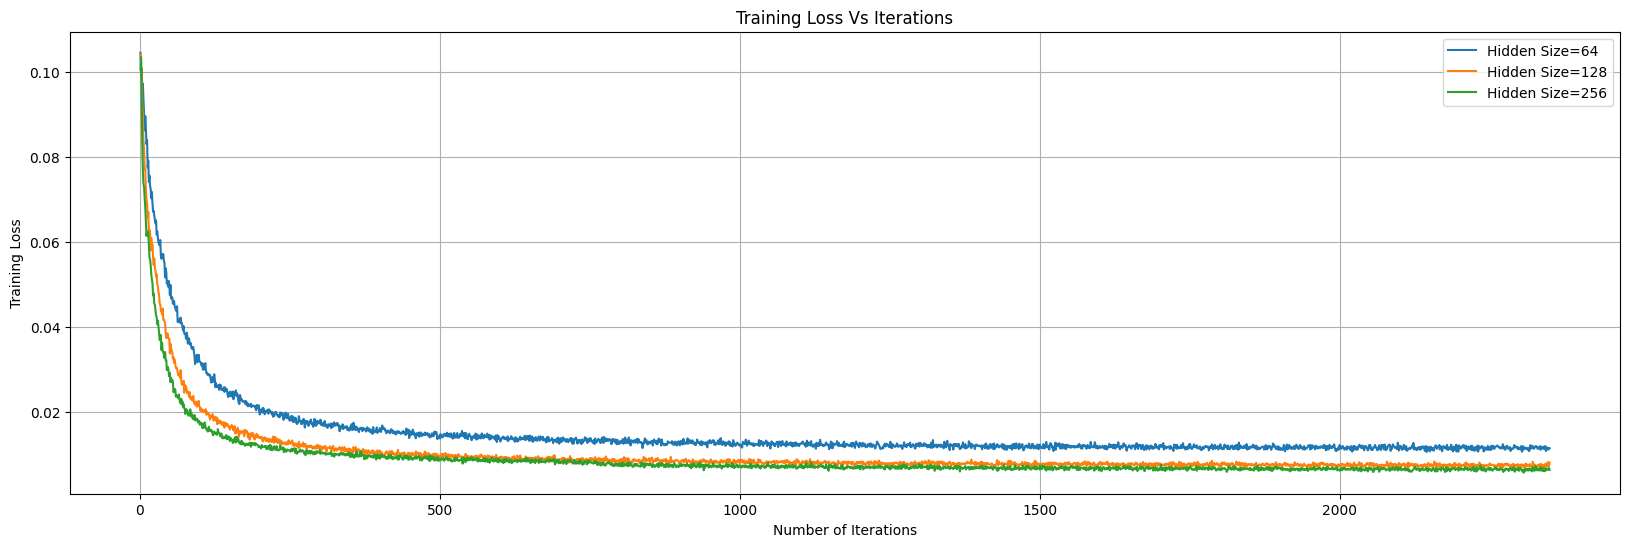

In [ ]:
plt.plot(range(1,len(training_loss_hid64)+1),training_loss_hid64,label="Hidden Size=64")
plt.plot(range(1,len(training_loss_hid128)+1),training_loss_hid128,label="Hidden Size=128")
plt.plot(range(1,len(training_loss_hid256)+1),training_loss_hid256,label="Hidden Size=256")
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()


Reconstruction Error in AE_hid64: 22.084072923718914
Reconstruction Error in AE_hid128: 15.481209502901311
Reconstruction Error in AE_hid256: 12.704462646306368


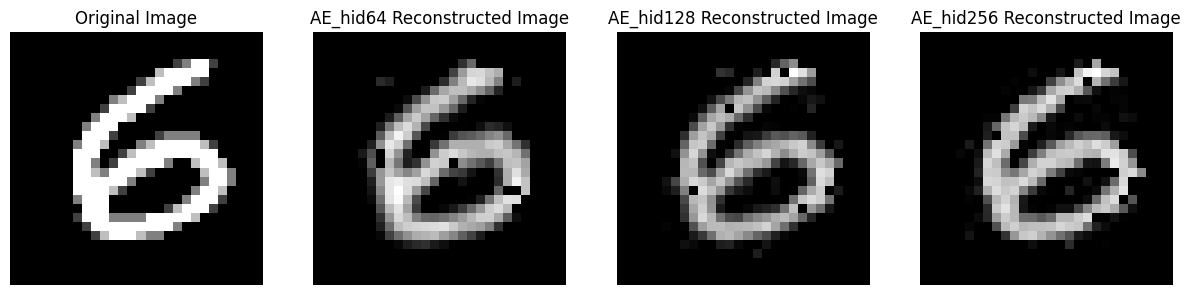

In [ ]:
model_hid64.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid64,_ = model_hid64(images.float())

model_hid128.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid128,_ = model_hid128(images.float())


model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid256,activations_hid256 = model_hid256(images.float())


plt.rcParams["figure.figsize"] = (15,6)
i=5
if i==5:
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_hid64[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('AE_hid64 Reconstructed Image')
  ax2.axis("off")

  ax3.imshow(outputs_hid128[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('AE_hid128 Reconstructed Image')
  ax3.axis("off")

  ax4.imshow(outputs_hid256[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('AE_hid256 Reconstructed Image')
  ax4.axis("off")

  print("Reconstruction Error in AE_hid64:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid64[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hid64[i].detach().numpy()/255)).T))
  print("Reconstruction Error in AE_hid128:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid128[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hid128[i].detach().numpy()/255)).T))
  print("Reconstruction Error in AE_hid256:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid256[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hid256[i].detach().numpy()/255)).T))

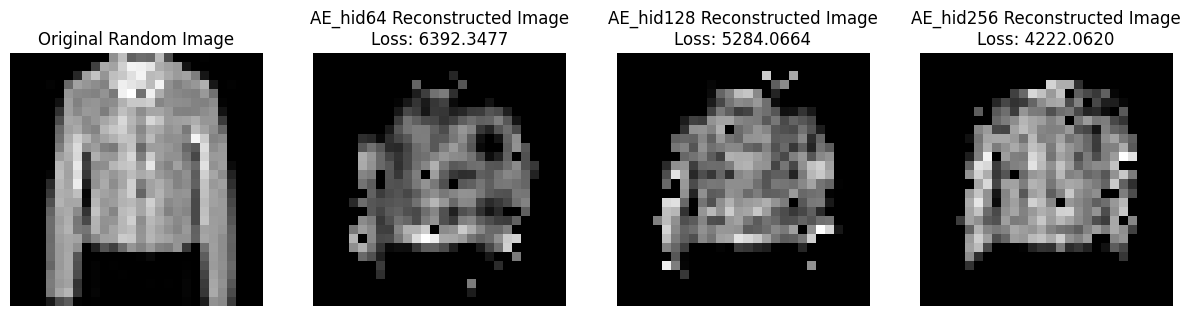

Reconstruction Loss for AE_hid64: 6392.3477
Reconstruction Loss for AE_hid128: 5284.0664
Reconstruction Loss for AE_hid256: 4222.0620


In [ ]:
#FASHION MNIST OUTPUT

# Load Fashion MNIST dataset
test_data_fashion = torchvision.datasets.FashionMNIST(root="./", train=False, transform=transforms.ToTensor(), download=True)
fashion_image_sample = test_data_fashion.data[10]

# Set the models to evaluation mode and compute outputs
models = [model_hid64, model_hid128, model_hid256]
outputs = []
losses = []

# Criterion for calculating reconstruction loss
criterion = nn.MSELoss()

plt.rcParams["figure.figsize"] = (15, 6)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

# Original Image
ax1.imshow(fashion_image_sample.detach().numpy().reshape(28, 28), cmap='gray')
ax1.set_title('Original Random Image')
ax1.axis("off")

for i, model in enumerate(models):
    model.eval()
    with torch.no_grad():
        images = fashion_image_sample.reshape(1, 28 * 28)
        output, _ = model(images.float())
        outputs.append(output)

        # Calculate reconstruction loss
        loss = criterion(output, images.float())
        losses.append(loss.item())

        # Plot reconstructed images
        ax = ax2 if i == 0 else (ax3 if i == 1 else ax4)
        ax.imshow(output.detach().numpy().reshape(28, 28), cmap='gray')
        ax.set_title(f'AE_hid{[64, 128, 256][i]} Reconstructed Image\nLoss: {losses[i]:.4f}')
        ax.axis("off")

plt.show()

# Print reconstruction losses
for i, loss in enumerate(losses):
    print(f'Reconstruction Loss for AE_hid{[64, 128, 256][i]}: {loss:.4f}')


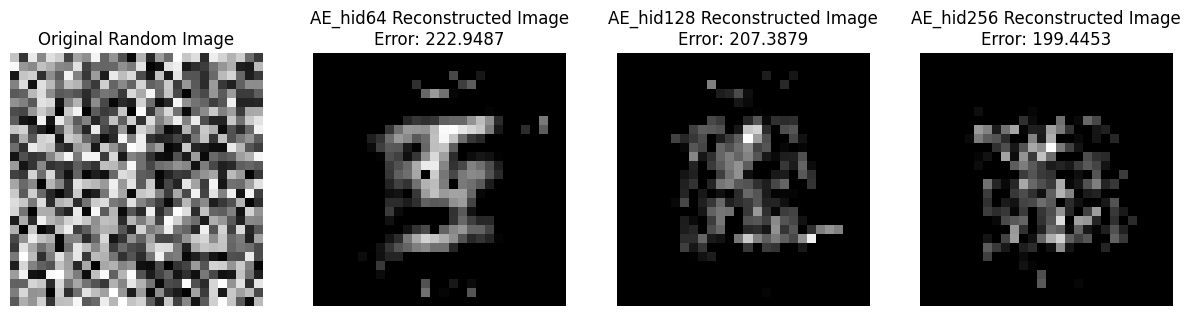

In [ ]:
# OUTPUTS FOR RANDOM IMAGE
torch.manual_seed(0)
random_image = torch.randint(low=0, high=255, size=(1, 28, 28))

# Initialize lists to store the reconstruction errors
reconstruction_errors = {}

# Evaluate model with hidden size 64
model_hid64.eval()
with torch.no_grad():
    images = random_image.reshape(1, 28 * 28)
    outputs_hid64, _ = model_hid64(images.float())
    reconstruction_errors['AE_hid64'] = np.dot(((images.numpy()/255) - (outputs_hid64.numpy()/255)),
                                                ((images.numpy()/255) - (outputs_hid64.numpy()/255)).T)

# Evaluate model with hidden size 128
model_hid128.eval()
with torch.no_grad():
    images = random_image.reshape(1, 28 * 28)
    outputs_hid128, _ = model_hid128(images.float())
    reconstruction_errors['AE_hid128'] = np.dot(((images.numpy()/255) - (outputs_hid128.numpy()/255)),
                                                 ((images.numpy()/255) - (outputs_hid128.numpy()/255)).T)

# Evaluate model with hidden size 256
model_hid256.eval()
with torch.no_grad():
    images = random_image.reshape(1, 28 * 28)
    outputs_hid256, _ = model_hid256(images.float())
    reconstruction_errors['AE_hid256'] = np.dot(((images.numpy()/255) - (outputs_hid256.numpy()/255)),
                                                 ((images.numpy()/255) - (outputs_hid256.numpy()/255)).T)

# Plotting
plt.rcParams["figure.figsize"] = (15, 6)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

# Display the original random image
ax1.imshow(random_image.numpy().reshape(28, 28), cmap='gray')
ax1.set_title('Original Random Image')
ax1.axis("off")

# Display the reconstructed images and print reconstruction errors
ax2.imshow(outputs_hid64.detach().numpy().reshape(28, 28), cmap='gray')
ax2.set_title('AE_hid64 Reconstructed Image\nError: {:.4f}'.format(reconstruction_errors['AE_hid64'][0, 0]))
ax2.axis("off")

ax3.imshow(outputs_hid128.detach().numpy().reshape(28, 28), cmap='gray')
ax3.set_title('AE_hid128 Reconstructed Image\nError: {:.4f}'.format(reconstruction_errors['AE_hid128'][0, 0]))
ax3.axis("off")

ax4.imshow(outputs_hid256.detach().numpy().reshape(28, 28), cmap='gray')
ax4.set_title('AE_hid256 Reconstructed Image\nError: {:.4f}'.format(reconstruction_errors['AE_hid256'][0, 0]))
ax4.axis("off")

plt.show()

**Observations:**
- For an image sample from MNIST dataset, AE with hidden size 256 seems to reconstruct the image in a better manner. This was expected as more components would able to reproduce the image in a better manner by capturing the minor details of the input image. This is also proved by the lesser reconstruction error by this model.

- For an image from Fashion MNIST dataset, the models try to reconstruct the image but the models with 64 and 128 hidden size could not reconstruct properly. On the other hand, 256 hidden size model does better job than them but also seems to struggle in the reconstruction, though if the model was trained on fashion mnist dataset, it would've performed better.

- For a random image, the models perform as if they were trying to find out the digits, so the center pixels have some noisy output and the outer/edge pixels seem to be off (similar to the MNIST digit dataset, as our model has been trained on them.)

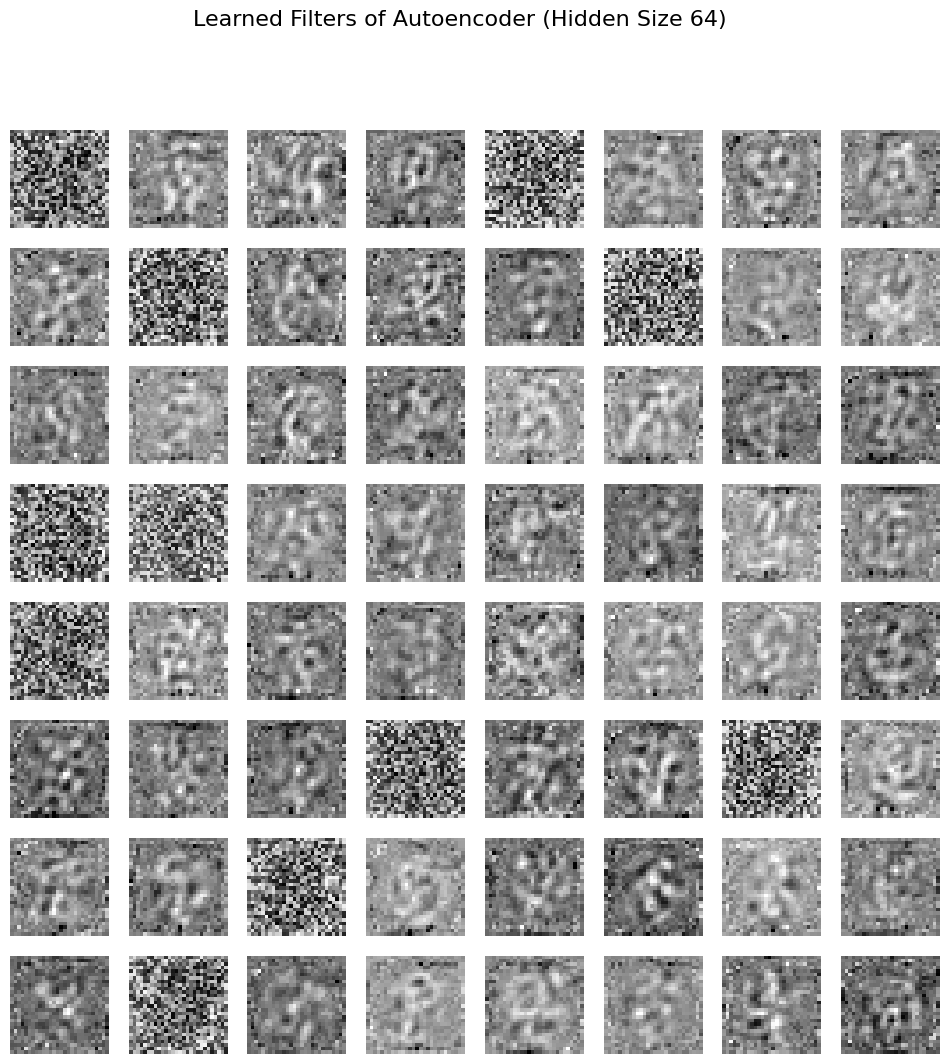

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Extract the weights from the first encoder layer
weights = model_hid64.encoder[0].weight.detach().numpy()  # Adjust the layer index as needed

# Normalize the weights to the range [0, 1] for visualization
weights_min = np.min(weights)
weights_max = np.max(weights)
weights_normalized = (weights - weights_min) / (weights_max - weights_min)

# Determine the number of filters (hidden nodes)
num_filters = weights_normalized.shape[0]
# Calculate the grid size for visualization
grid_size = int(np.ceil(np.sqrt(num_filters)))

# Set the figure size for the plots
plt.rcParams["figure.figsize"] = (12, 12)

# Create a grid to display the filters
fig, axes = plt.subplots(grid_size, grid_size)

for i in range(grid_size):
    for j in range(grid_size):
        index = i * grid_size + j
        if index < num_filters:
            ax = axes[i, j]
            ax.imshow(weights_normalized[index].reshape(28, 28), cmap='gray')  # Reshape as per input image size
            ax.axis('off')
        else:
            axes[i, j].axis('off')  # Turn off unused axes

plt.suptitle('Learned Filters of Autoencoder (Hidden Size 64)', fontsize=16)
plt.show()


Edge Detection:
- Many filters highlight vertical and horizontal edges, which are essential for recognizing digit outlines.
Digit Components:

- Some filters capture features specific to certain digits, such as the curvature of '0', '6', and '9'.

Shape and Structure:

- Filters often represent structural features, such as the loops in '8' or the straight lines in '1', aiding in digit classification.

Variability:

- Filters show variability across different digits, suggesting that the Autoencoder has learned to distinguish between shapes and styles of the numbers.

Hierarchical Learning:

- Lower layers may learn basic features (e.g., edges and corners), while higher layers capture more complex features (e.g., complete digits).

Noise Robustness:

- Some filters appear to generalize well to variations in handwriting styles, indicating the model’s ability to handle noise.

Dimensionality Reduction:

- The learned filters can be seen as a compressed representation of the digits, facilitating efficient reconstruction and analysis of the digit images.

These observations suggest that the Autoencoder has effectively learned to represent the essential features of MNIST digits, highlighting its potential for applications in tasks like digit recognition and data compression.

#**Sparse Autoencoders**

In [ ]:
class AE3_SparseAutoencoder(nn.Module):
  def __init__(self):
    super(AE3_SparseAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,1156),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(1156,784),
        nn.ReLU())

  def forward(self,x):
    x=self.encoder(x)
    encoded_output=x
    l1_norm=torch.norm(x,p=1)
    x=self.decoder(x)
    return x,l1_norm,encoded_output

In [ ]:
# Set lambda for L1 regularization
lambda_ = 1 * 1e-6
epochs= 10
# Initialize model, criterion, and optimizer
model_3_a = AE3_SparseAutoencoder()
criterion_3_a = nn.MSELoss()
optimizer_3_a = torch.optim.Adam(model_3_a.parameters(), lr=learning_rate)

# List to store training losses
training_loss_3_a = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0  # Variable to accumulate epoch loss
    for images, labels in train_loader:
        images = images.reshape(images.shape[0], -1)

        # Forward pass
        outputs, l1_norm, _ = model_3_a(images)

        # Calculate loss with L1 regularization
        loss = criterion_3_a(outputs, images) + lambda_ * l1_norm

        # Backward pass and optimization
        optimizer_3_a.zero_grad()
        loss.backward()
        optimizer_3_a.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    training_loss_3_a.append(avg_epoch_loss)

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f} (including L1 regularization)")


Epoch [1/10] - Loss: 0.0295 (including L1 regularization)
Epoch [2/10] - Loss: 0.0150 (including L1 regularization)
Epoch [3/10] - Loss: 0.0128 (including L1 regularization)
Epoch [4/10] - Loss: 0.0116 (including L1 regularization)
Epoch [5/10] - Loss: 0.0108 (including L1 regularization)
Epoch [6/10] - Loss: 0.0102 (including L1 regularization)
Epoch [7/10] - Loss: 0.0097 (including L1 regularization)
Epoch [8/10] - Loss: 0.0093 (including L1 regularization)
Epoch [9/10] - Loss: 0.0089 (including L1 regularization)
Epoch [10/10] - Loss: 0.0086 (including L1 regularization)


In [ ]:
# Set lambda for L1 regularization
lambda_ = 1 * 1e-5
epochs= 10
# Initialize model, criterion, and optimizer
model_3_b = AE3_SparseAutoencoder()
criterion_3_b = nn.MSELoss()
optimizer_3_b = torch.optim.Adam(model_3_b.parameters(), lr=learning_rate)

# List to store training losses
training_loss_3_b = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0  # Variable to accumulate epoch loss
    for images, labels in train_loader:
        images = images.reshape(images.shape[0], -1)

        # Forward pass
        outputs, l1_norm, _ = model_3_b(images)

        # Calculate loss with L1 regularization
        loss = criterion_3_b(outputs, images) + lambda_ * l1_norm

        # Backward pass and optimization
        optimizer_3_b.zero_grad()
        loss.backward()
        optimizer_3_b.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    training_loss_3_b.append(avg_epoch_loss)

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f} (including L1 regularization)")

Epoch [1/10] - Loss: 0.0969 (including L1 regularization)
Epoch [2/10] - Loss: 0.0812 (including L1 regularization)
Epoch [3/10] - Loss: 0.0781 (including L1 regularization)
Epoch [4/10] - Loss: 0.0775 (including L1 regularization)
Epoch [5/10] - Loss: 0.0775 (including L1 regularization)
Epoch [6/10] - Loss: 0.0775 (including L1 regularization)
Epoch [7/10] - Loss: 0.0775 (including L1 regularization)
Epoch [8/10] - Loss: 0.0775 (including L1 regularization)
Epoch [9/10] - Loss: 0.0775 (including L1 regularization)
Epoch [10/10] - Loss: 0.0775 (including L1 regularization)


In [ ]:
# Set lambda for L1 regularization
lambda_ = 1 * 1e-4
epochs= 10
# Initialize model, criterion, and optimizer
model_3_c = AE3_SparseAutoencoder()
criterion_3_c = nn.MSELoss()
optimizer_3_c = torch.optim.Adam(model_3_c.parameters(), lr=learning_rate)

# List to store training losses
training_loss_3_c = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0  # Variable to accumulate epoch loss
    for images, labels in train_loader:
        images = images.reshape(images.shape[0], -1)

        # Forward pass
        outputs, l1_norm, _ = model_3_c(images)

        # Calculate loss with L1 regularization
        loss = criterion_3_c(outputs, images) + lambda_ * l1_norm

        # Backward pass and optimization
        optimizer_3_c.zero_grad()
        loss.backward()
        optimizer_3_c.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    training_loss_3_c.append(avg_epoch_loss)

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_epoch_loss:.4f} (including L1 regularization)")

Epoch [1/10] - Loss: 0.1128 (including L1 regularization)
Epoch [2/10] - Loss: 0.0828 (including L1 regularization)
Epoch [3/10] - Loss: 0.0800 (including L1 regularization)
Epoch [4/10] - Loss: 0.0795 (including L1 regularization)
Epoch [5/10] - Loss: 0.0795 (including L1 regularization)
Epoch [6/10] - Loss: 0.0795 (including L1 regularization)
Epoch [7/10] - Loss: 0.0794 (including L1 regularization)
Epoch [8/10] - Loss: 0.0793 (including L1 regularization)
Epoch [9/10] - Loss: 0.0793 (including L1 regularization)
Epoch [10/10] - Loss: 0.0793 (including L1 regularization)


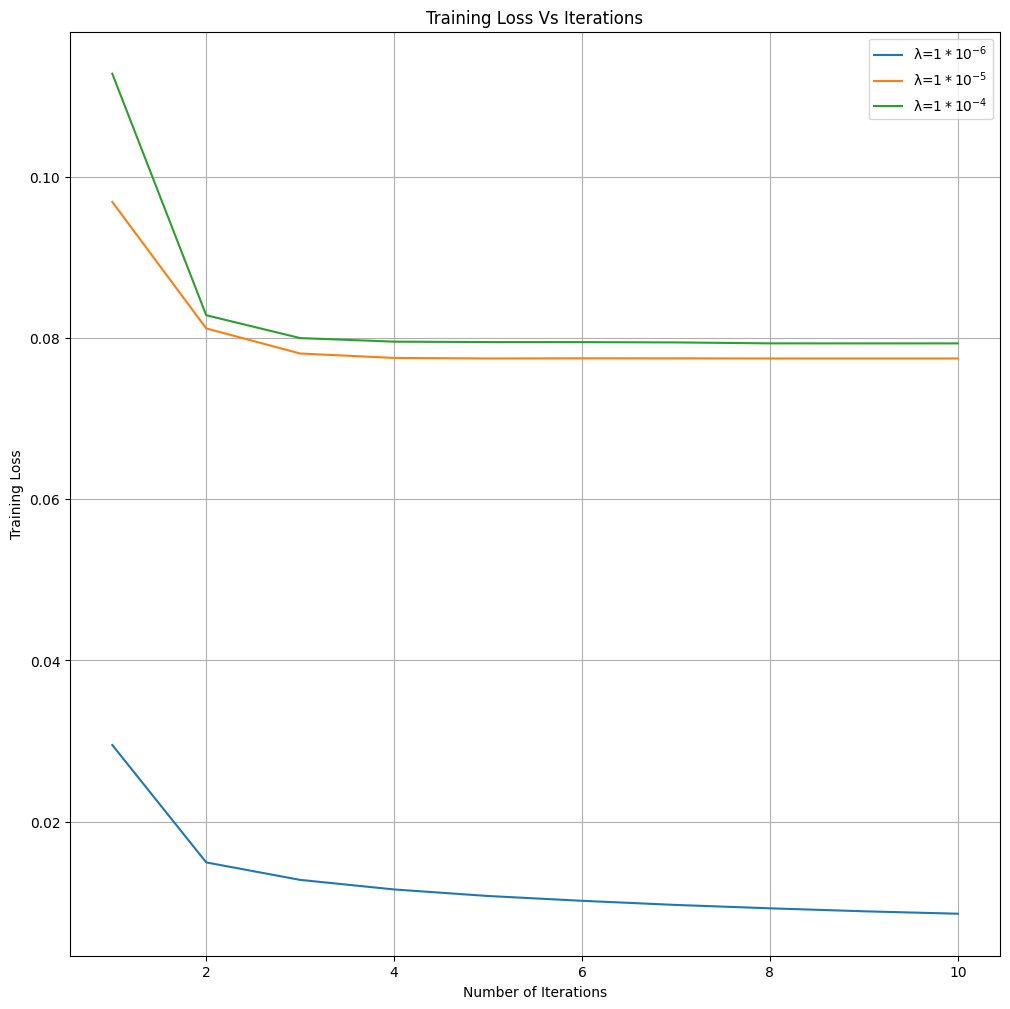

In [ ]:
plt.plot(range(1,len(training_loss_3_a)+1),training_loss_3_a,label="λ=$1*10^{-6}$")
plt.plot(range(1,len(training_loss_3_a)+1),training_loss_3_b,label="λ=$1*10^{-5}$")
plt.plot(range(1,len(training_loss_3_a)+1),training_loss_3_c,label="λ=$1*10^{-4}$")
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()


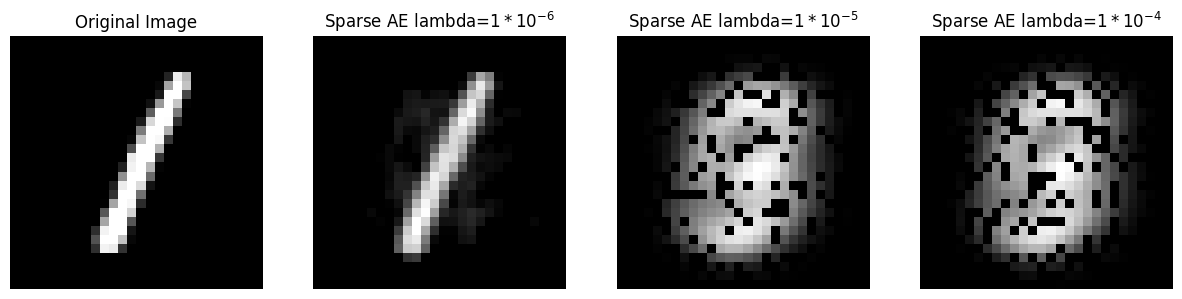

Reconstruction Error in SparseAE λ = 1*1e-6: 3.562504673493041
Reconstruction Error in SparseAE λ = 1*1e-5: 47.76665086547913
Reconstruction Error in SparseAE λ = 1*1e-4: 47.76881409034138
______________________________________________________________________________________________


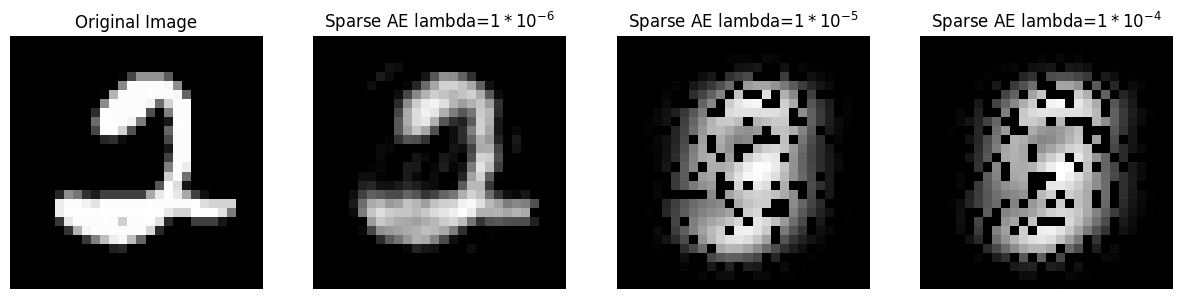

Reconstruction Error in SparseAE λ = 1*1e-6: 13.059560942836569
Reconstruction Error in SparseAE λ = 1*1e-5: 114.2811292577155
Reconstruction Error in SparseAE λ = 1*1e-4: 114.30503260973435
______________________________________________________________________________________________


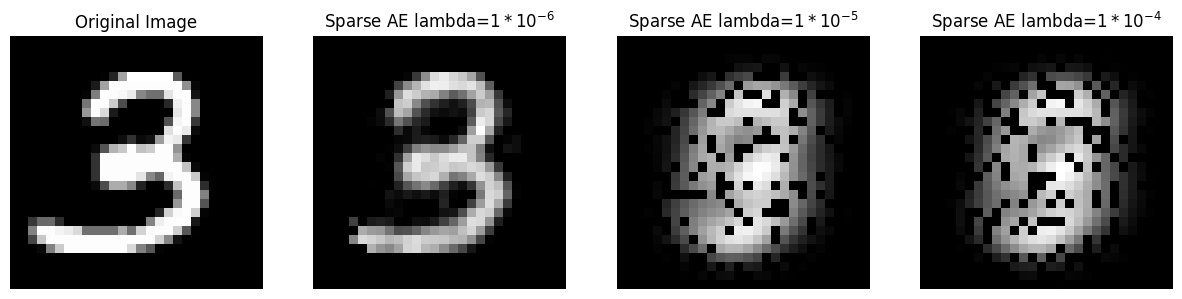

Reconstruction Error in SparseAE λ = 1*1e-6: 11.979831259337601
Reconstruction Error in SparseAE λ = 1*1e-5: 119.60605315038694
Reconstruction Error in SparseAE λ = 1*1e-4: 119.609050199548
______________________________________________________________________________________________


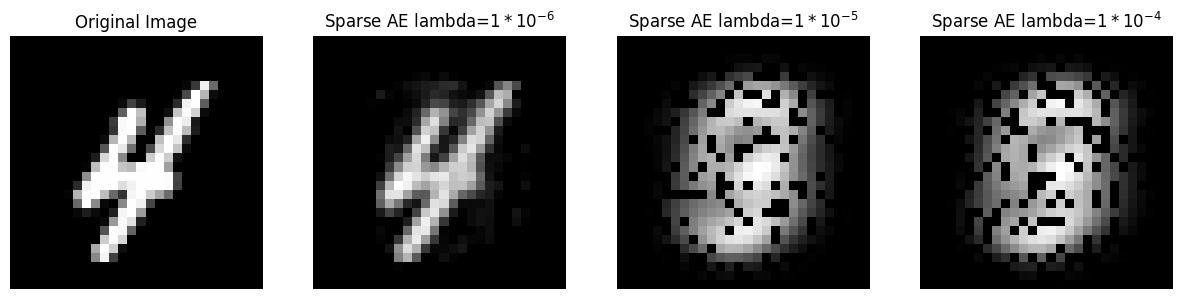

Reconstruction Error in SparseAE λ = 1*1e-6: 6.84872849367996
Reconstruction Error in SparseAE λ = 1*1e-5: 79.08692220978871
Reconstruction Error in SparseAE λ = 1*1e-4: 79.10138781248455
______________________________________________________________________________________________


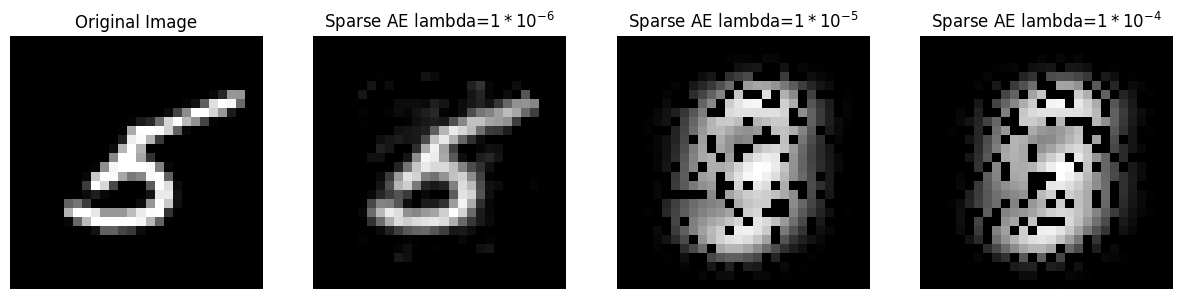

Reconstruction Error in SparseAE λ = 1*1e-6: 6.414019453175997
Reconstruction Error in SparseAE λ = 1*1e-5: 55.07611049870571
Reconstruction Error in SparseAE λ = 1*1e-4: 55.08305633264402
______________________________________________________________________________________________


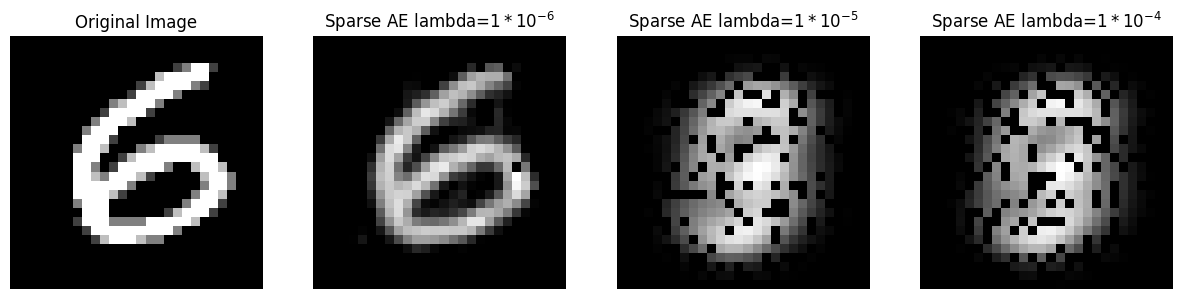

Reconstruction Error in SparseAE λ = 1*1e-6: 13.765464797562657
Reconstruction Error in SparseAE λ = 1*1e-5: 131.18994794171863
Reconstruction Error in SparseAE λ = 1*1e-4: 131.21599974547468
______________________________________________________________________________________________


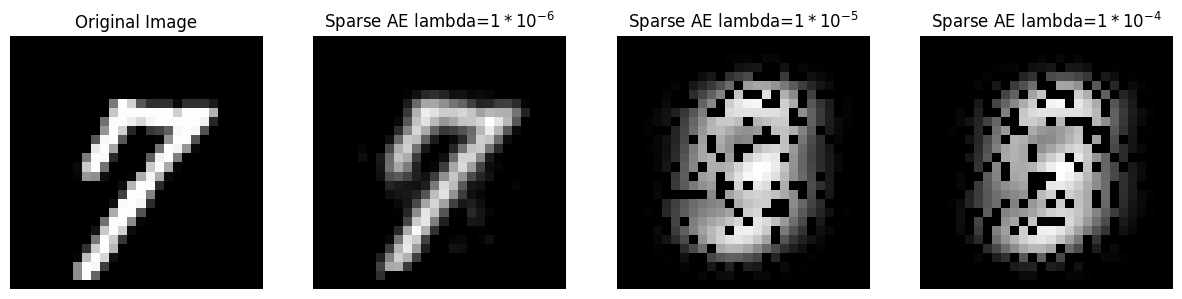

Reconstruction Error in SparseAE λ = 1*1e-6: 7.269245388821619
Reconstruction Error in SparseAE λ = 1*1e-5: 73.52382924375961
Reconstruction Error in SparseAE λ = 1*1e-4: 73.54789156876805
______________________________________________________________________________________________


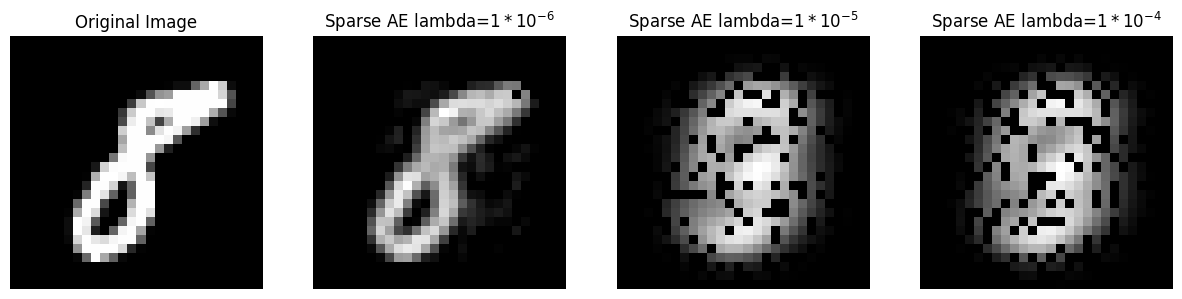

Reconstruction Error in SparseAE λ = 1*1e-6: 12.288598237094437
Reconstruction Error in SparseAE λ = 1*1e-5: 102.02350773752107
Reconstruction Error in SparseAE λ = 1*1e-4: 102.02646721570278
______________________________________________________________________________________________


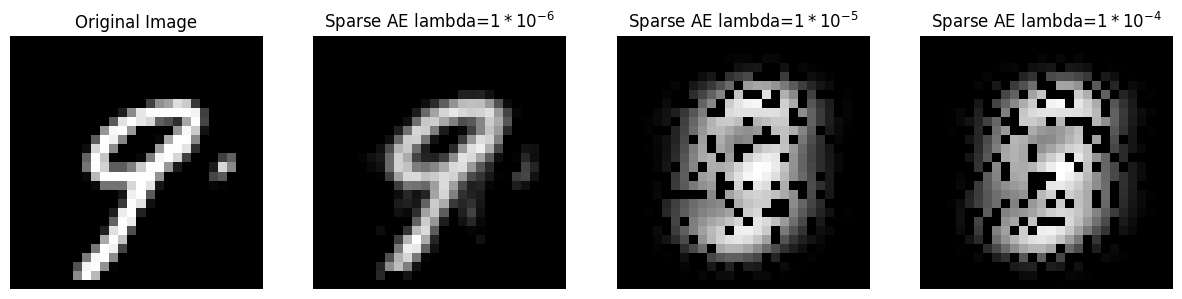

Reconstruction Error in SparseAE λ = 1*1e-6: 9.012632636878312
Reconstruction Error in SparseAE λ = 1*1e-5: 70.64328764713406
Reconstruction Error in SparseAE λ = 1*1e-4: 70.66243320756527
______________________________________________________________________________________________


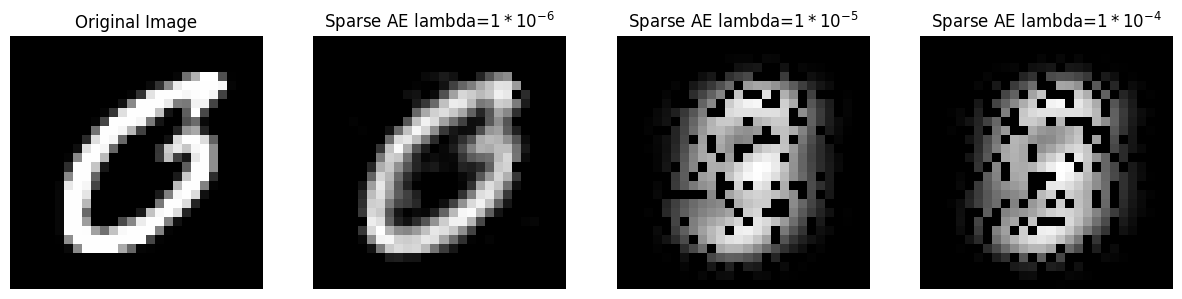

Reconstruction Error in SparseAE λ = 1*1e-6: 12.760878562161171
Reconstruction Error in SparseAE λ = 1*1e-5: 115.58458519082258
Reconstruction Error in SparseAE λ = 1*1e-4: 115.59485376822968
______________________________________________________________________________________________


In [ ]:
model_3_a.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    outputs_3_a,_,activation_3_a = model_3_a(images.float())


model_3_b.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    outputs_3_b,_,activation_3_b = model_3_b(images.float())


model_3_c.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    outputs_3_c,_ ,activation_3_c= model_3_c(images.float())


plt.rcParams["figure.figsize"] = (15,6)

for i in range(10):
  fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_3_a[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('Sparse AE lambda=$1*10^{-6}$')
  ax2.axis("off")

  ax3.imshow(outputs_3_b[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('Sparse AE lambda=$1*10^{-5}$')
  ax3.axis("off")

  ax4.imshow(outputs_3_c[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('Sparse AE lambda=$1*10^{-4}$')
  ax4.axis("off")

  plt.show()

  print("Reconstruction Error in SparseAE λ = 1*1e-6:",np.dot(((images[i].detach().numpy()/255)-(outputs_3_a[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_3_a[i].detach().numpy()/255)).T))
  print("Reconstruction Error in SparseAE λ = 1*1e-5:",np.dot(((images[i].detach().numpy()/255)-(outputs_3_b[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_3_b[i].detach().numpy()/255)).T))
  print("Reconstruction Error in SparseAE λ = 1*1e-4:",np.dot(((images[i].detach().numpy()/255)-(outputs_3_c[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_3_c[i].detach().numpy()/255)).T))
  print("______________________________________________________________________________________________")


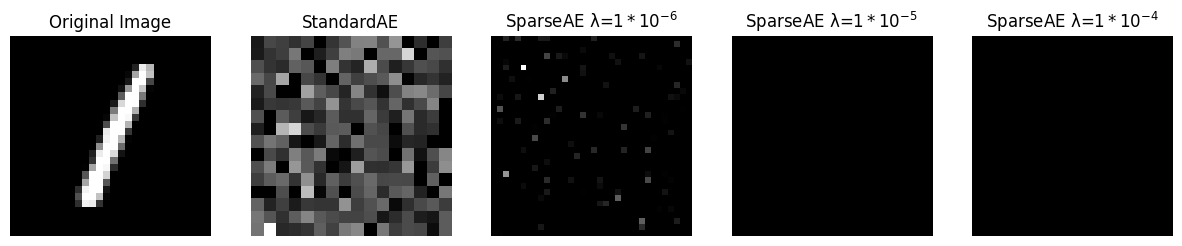

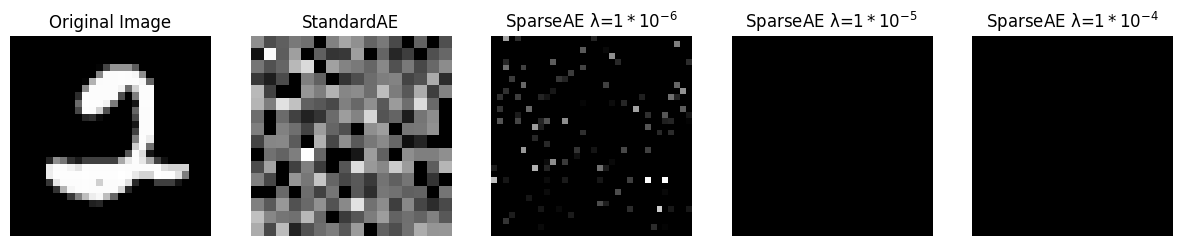

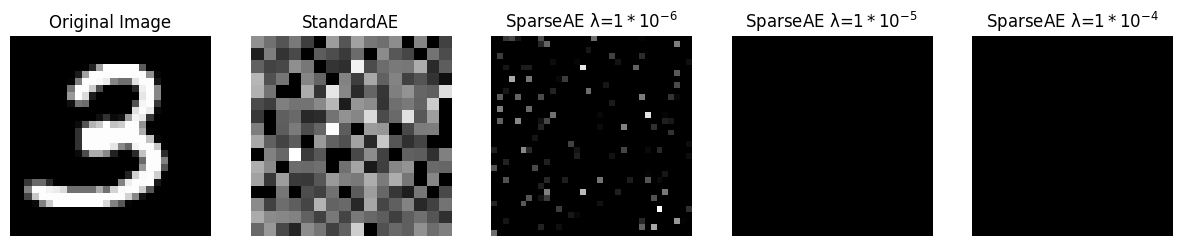

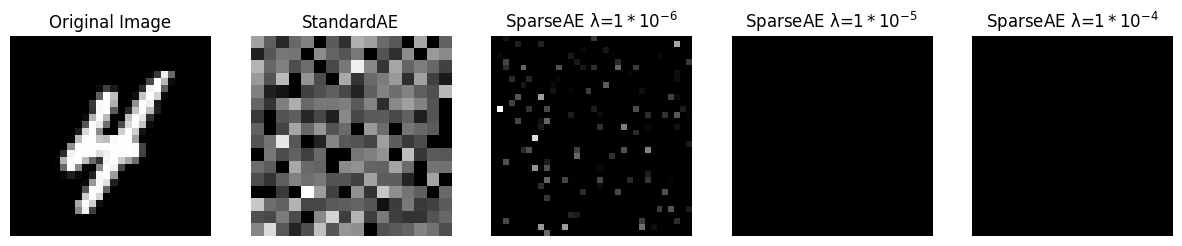

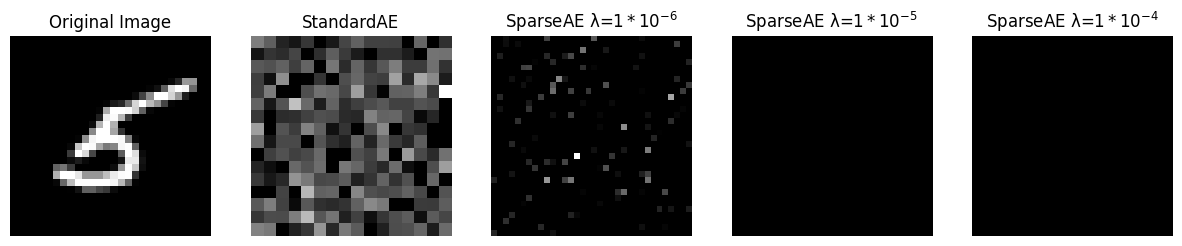

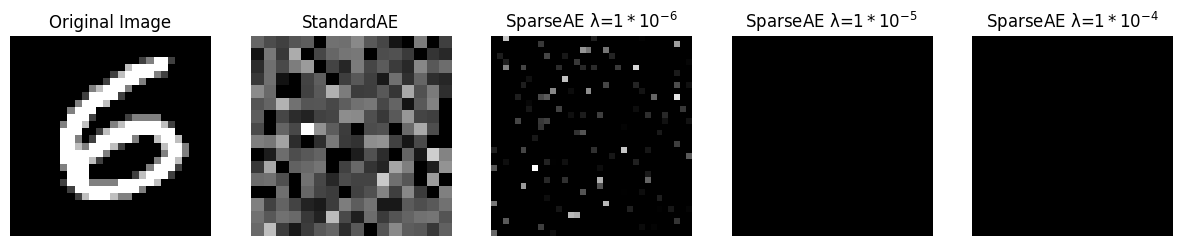

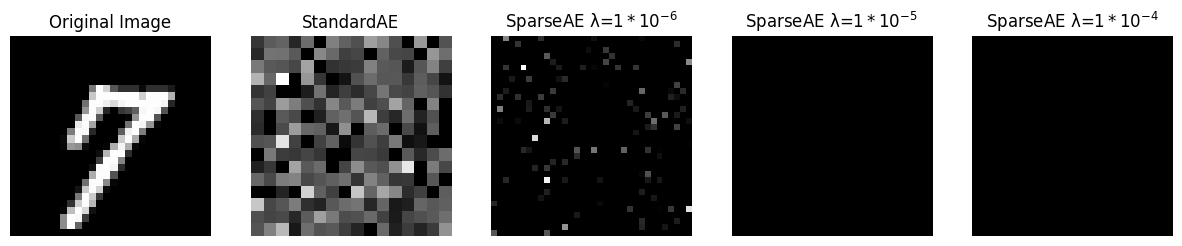

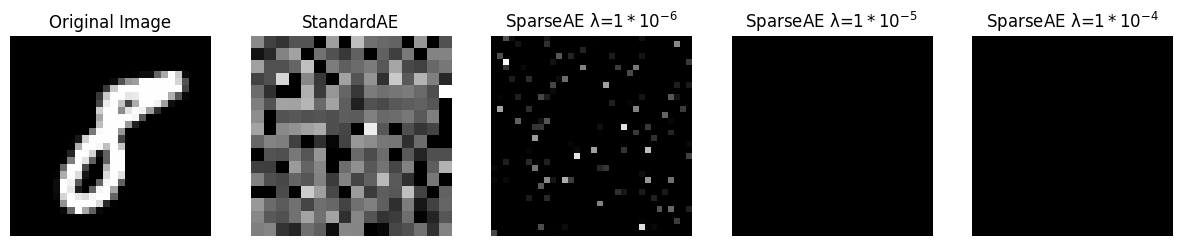

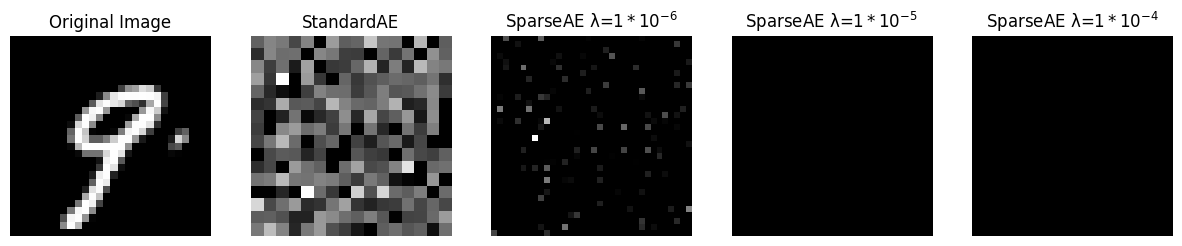

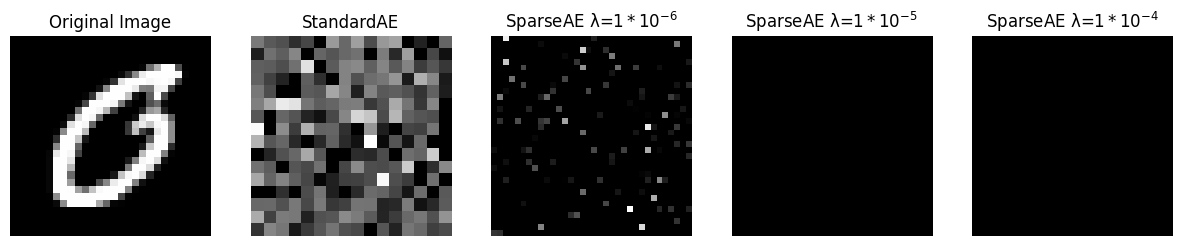

In [ ]:
##VISUALISING ACTIVATIONS

plt.rcParams["figure.figsize"] = (15,6)
for i in range(10):
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)
  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(np.array(activations_hid256.detach().numpy())[i].reshape(int(np.sqrt(256)),int(np.sqrt(256))),cmap='gray')
  ax2.set_title('StandardAE')
  ax2.axis("off")

  ax3.imshow(np.array(activation_3_a.detach().numpy())[i].reshape(int(np.sqrt(1156)),int(np.sqrt(1156))),cmap='gray')
  ax3.set_title('SparseAE λ=$1*10^{-6}$')
  ax3.axis("off")

  ax4.imshow(np.array(activation_3_b.detach().numpy())[i].reshape(int(np.sqrt(1156)),int(np.sqrt(1156))),cmap='gray')
  ax4.set_title('SparseAE λ=$1*10^{-5}$')
  ax4.axis("off")

  ax5.imshow(np.array(activation_3_c.detach().numpy())[i].reshape(int(np.sqrt(1156)),int(np.sqrt(1156))),cmap='gray')
  ax5.set_title('SparseAE λ=$1*10^{-4}$')
  ax5.axis("off")

plt.show()

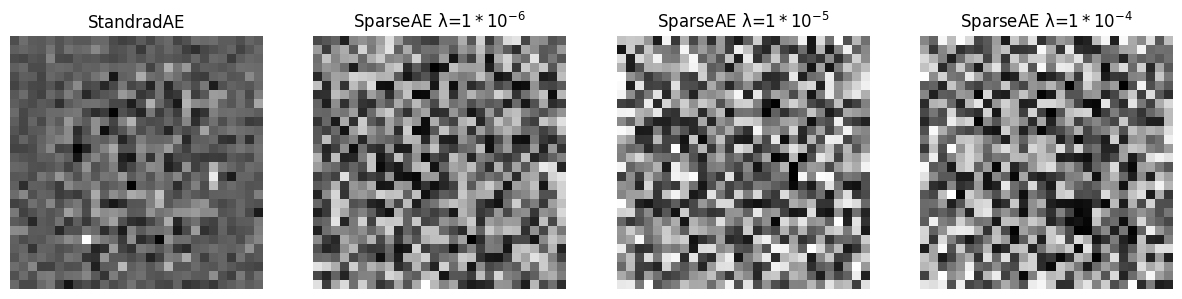

In [ ]:
##VISUALISING ENCODER WEIGHTS

plt.rcParams["figure.figsize"] = (15,6)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)
ax1.imshow(model_hid256.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax1.set_title('StandradAE')
ax1.axis("off")

ax2.imshow(model_3_a.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax2.set_title('SparseAE λ=$1*10^{-6}$')
ax2.axis("off")

ax3.imshow(model_3_b.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax3.set_title('SparseAE λ=$1*10^{-5}$')
ax3.axis("off")

ax4.imshow(model_3_c.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax4.set_title('SparseAE λ=$1*10^{-4}$')
ax4.axis("off")

plt.show()

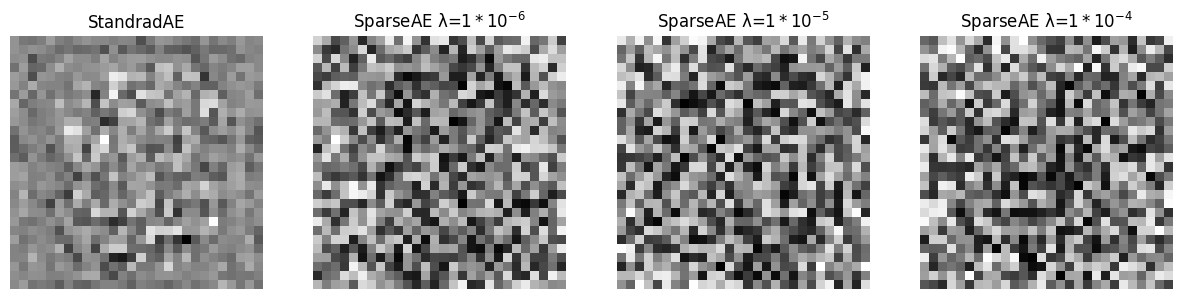

In [ ]:
##VISUALISING ENCODER WEIGHTS

plt.rcParams["figure.figsize"] = (15,6)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)
ax1.imshow(model_hid256.encoder[0].weight.detach().numpy()[6].reshape(28,28),cmap='gray')
ax1.set_title('StandradAE')
ax1.axis("off")

ax2.imshow(model_3_a.encoder[0].weight.detach().numpy()[6].reshape(28,28),cmap='gray')
ax2.set_title('SparseAE λ=$1*10^{-6}$')
ax2.axis("off")

ax3.imshow(model_3_b.encoder[0].weight.detach().numpy()[6].reshape(28,28),cmap='gray')
ax3.set_title('SparseAE λ=$1*10^{-5}$')
ax3.axis("off")

ax4.imshow(model_3_c.encoder[0].weight.detach().numpy()[6].reshape(28,28),cmap='gray')
ax4.set_title('SparseAE λ=$1*10^{-4}$')
ax4.axis("off")

plt.show()

**Observations:**
- As lambda(sparsity factor) is decreased, reconstruction error goes down.
- If the lambda is continually decreased beyond a point then the model starts to overfit data. since the model is overcomplete, we need to iterate over the optimal lambda parameter to get desired output.

- as we decrease lambda(sparcity parameter) more neurons get activated. As can be observed from activation visualisations. However, in vanilla AE all the neurons are activated.

- Visualisation of encoder weights is difficult as nothing could be inferred from the images.

#**Denoising Autoencoders**

In [ ]:
class AE4_DenoisingAutoencoder(nn.Module):
  def __init__(self):
    super(AE4_DenoisingAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,256),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(256,784),
        nn.ReLU())

  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

In [ ]:
def add_noise(img, noise_val):
    noise = torch.randn(img.size())*noise_val
    noisy_img = img + noise
    return noisy_img

In [ ]:
#HYPERPARAMETERS
learning_rate=0.0008
epochs=10
batch_size= 256

In [ ]:
model_4_a=AE4_DenoisingAutoencoder()
criterion_4_a=nn.MSELoss()
optimizer_4_a = torch.optim.Adam(model_4_a.parameters(),lr=learning_rate)

training_loss_4_a=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    noisy_images=add_noise(images,0.3)
    outputs=model_4_a(noisy_images)
    loss=criterion_4_a(outputs,images)
    training_loss_4_a.append(loss.item())

    optimizer_4_a.zero_grad()
    loss.backward()
    optimizer_4_a.step()

  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [ ]:
model_4_b=AE4_DenoisingAutoencoder()
criterion_4_b=nn.MSELoss()
optimizer_4_b = torch.optim.Adam(model_4_b.parameters(),lr=learning_rate)

training_loss_4_b=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    noisy_images=add_noise(images,0.5)
    outputs=model_4_b(noisy_images)
    loss=criterion_4_b(outputs,images)
    training_loss_4_b.append(loss.item())

    optimizer_4_b.zero_grad()
    loss.backward()
    optimizer_4_b.step()

  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [ ]:
model_4_c=AE4_DenoisingAutoencoder()
criterion_4_c=nn.MSELoss()
optimizer_4_c = torch.optim.Adam(model_4_c.parameters(),lr=learning_rate)

training_loss_4_c=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    noisy_images=add_noise(images,0.8)
    outputs=model_4_c(noisy_images)
    loss=criterion_4_c(outputs,images)
    training_loss_4_c.append(loss.item())

    optimizer_4_c.zero_grad()
    loss.backward()
    optimizer_4_c.step()

  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [ ]:
model_4_d=AE4_DenoisingAutoencoder()
criterion_4_d=nn.MSELoss()
optimizer_4_d = torch.optim.Adam(model_4_d.parameters(),lr=learning_rate)

training_loss_4_d=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    noisy_images=add_noise(images,0.9)
    outputs=model_4_d(noisy_images)
    loss=criterion_4_d(outputs,images)
    training_loss_4_d.append(loss.item())

    optimizer_4_d.zero_grad()
    loss.backward()
    optimizer_4_d.step()

  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


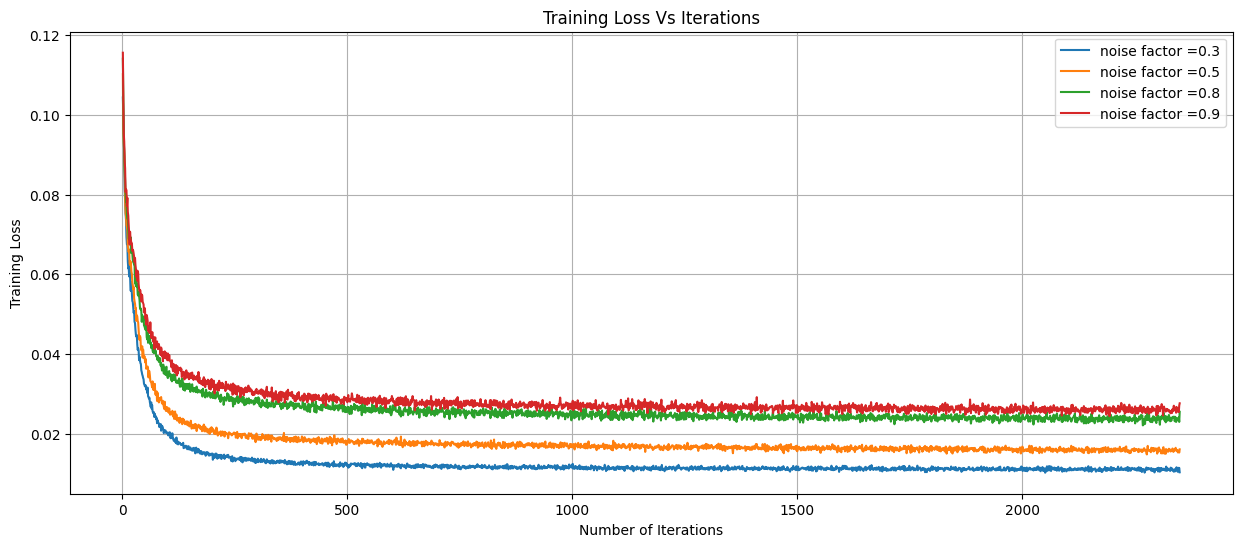

In [ ]:
plt.rcParams["figure.figsize"] = (15,6)

plt.plot(range(1,len(training_loss_4_a)+1),training_loss_4_a,label="noise factor =0.3")
plt.plot(range(1,len(training_loss_4_a)+1),training_loss_4_b,label="noise factor =0.5")
plt.plot(range(1,len(training_loss_4_a)+1),training_loss_4_c,label="noise factor =0.8")
plt.plot(range(1,len(training_loss_4_a)+1),training_loss_4_d,label="noise factor =0.9")
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()

Reconstruction Error in StandardAE with noise factor = 0.3 : 12.708732499861467
Reconstruction Error in StandardAE with noise factor = 0.5 : 12.689272416002737
Reconstruction Error in StandardAE with noise factor = 0.8 : 12.704175335761287
Reconstruction Error in StandardAE with noise factor = 0.9 : 12.711788004726792


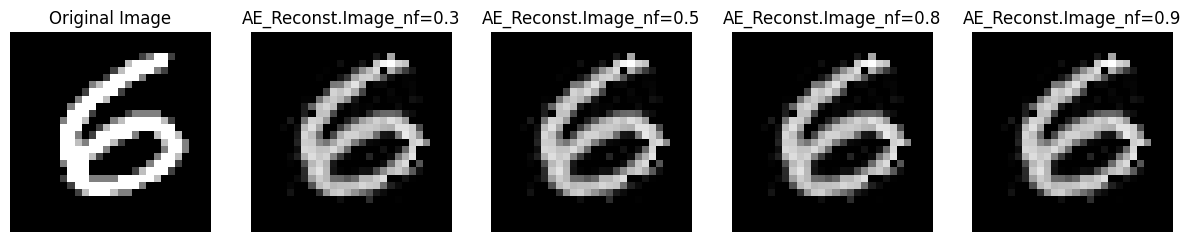

In [ ]:
#INPUT WITH NOISE FACTOR=0.3,0.5,0.8,0.9 GIVEN TO STANDARD AE HIDLAYER=256
model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    noisy_images=add_noise(images,0.3)
    outputs_hid256_03,activations_hid256 = model_hid256(noisy_images.float())

model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images=add_noise(images,0.5)
    outputs_hid256_05,activations_hid256 = model_hid256(noisy_images.float())

model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images=add_noise(images,0.8)
    outputs_hid256_08,activations_hid256 = model_hid256(noisy_images.float())

model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images=add_noise(images,0.9)
    outputs_hid256_09,activations_hid256 = model_hid256(noisy_images.float())

plt.rcParams["figure.figsize"] = (15,6)
i=5
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)

ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Image')
ax1.axis("off")

ax2.imshow(outputs_hid256_03[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('AE_Reconst.Image_nf=0.3')
ax2.axis("off")

ax3.imshow(outputs_hid256_05[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('AE_Reconst.Image_nf=0.5')
ax3.axis("off")

ax4.imshow(outputs_hid256_08[i].detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title('AE_Reconst.Image_nf=0.8')
ax4.axis("off")

ax5.imshow(outputs_hid256_09[i].detach().numpy().reshape(28,28),cmap='gray')
ax5.set_title('AE_Reconst.Image_nf=0.9')
ax5.axis("off")

print("Reconstruction Error in StandardAE with noise factor = 0.3 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_03[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_03[i].detach().numpy()/255.)).T))
print("Reconstruction Error in StandardAE with noise factor = 0.5 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_05[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_05[i].detach().numpy()/255.)).T))
print("Reconstruction Error in StandardAE with noise factor = 0.8 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_08[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_08[i].detach().numpy()/255.)).T))
print("Reconstruction Error in StandardAE with noise factor = 0.9 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_09[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_09[i].detach().numpy()/255.)).T))

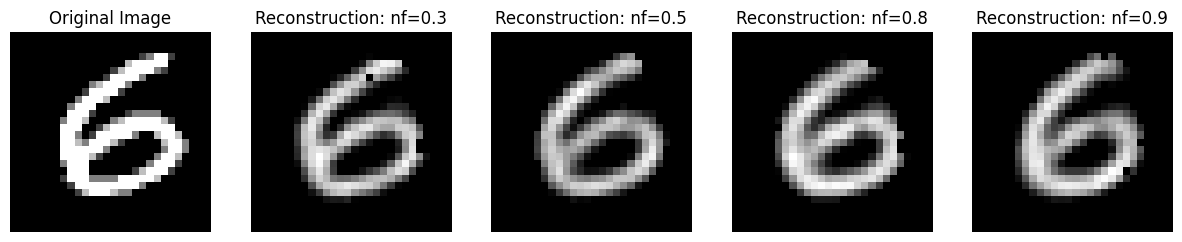

Reconstruction Error in DenoisingAE with noise factor = 0.3 : 11.899540434699826
Reconstruction Error in DenoisingAE with noise factor = 0.5 : 11.693956936036919
Reconstruction Error in DenoisingAE with noise factor = 0.8 : 20.232822123745233
Reconstruction Error in DenoisingAE with noise factor = 0.9 : 21.920191710208133
______________________________________________________________________________________________


In [ ]:
model_4_a.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.3)
    outputs_4_a = model_4_a(noisy_images.float())

model_4_b.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.5)
    outputs_4_b = model_4_b(noisy_images.float())

model_4_c.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.8)
    outputs_4_c = model_4_c(noisy_images.float())

model_4_d.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.9)
    outputs_4_d = model_4_d(noisy_images.float())

plt.rcParams["figure.figsize"] = (15,6)
i=5
if i==5:
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_4_a[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('Reconstruction: nf=0.3')
  ax2.axis("off")

  ax3.imshow(outputs_4_b[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('Reconstruction: nf=0.5')
  ax3.axis("off")

  ax4.imshow(outputs_4_c[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('Reconstruction: nf=0.8')
  ax4.axis("off")

  ax5.imshow(outputs_4_d[i].detach().numpy().reshape(28,28),cmap='gray')
  ax5.set_title('Reconstruction: nf=0.9')
  ax5.axis("off")

  plt.show()

  print("Reconstruction Error in DenoisingAE with noise factor = 0.3 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_a[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_a[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.5 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_b[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_b[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.8 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_c[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_c[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.9 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_d[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_d[i].detach().numpy()/255.)).T))
  print("______________________________________________________________________________________________")


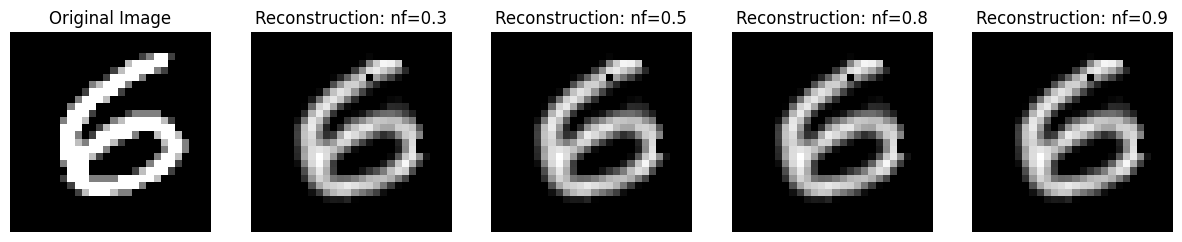

Reconstruction Error in DenoisingAE with noise factor = 0.3 : 11.894745455874139
Reconstruction Error in DenoisingAE with noise factor = 0.5 : 11.898799213156467
Reconstruction Error in DenoisingAE with noise factor = 0.8 : 11.89442192037134
Reconstruction Error in DenoisingAE with noise factor = 0.9 : 11.895282881344349
______________________________________________________________________________________________


In [ ]:
#DENOISING ENCODER TRAINED ON NOISE LEVEL=0.3 AND TESTED RECONSTRUCTION FOR NOISE LEVEL 0.3,0.5,0.8,0.9
model_4_a.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.3)
    outputs_4_a = model_4_a(noisy_images.float())
    noisy_images = add_noise(images,0.5)
    outputs_4_b = model_4_a(noisy_images.float())
    noisy_images = add_noise(images,0.8)
    outputs_4_c = model_4_a(noisy_images.float())
    noisy_images = add_noise(images,0.9)
    outputs_4_d = model_4_a(noisy_images.float())
i=5
if i==5:
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_4_a[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('Reconstruction: nf=0.3')
  ax2.axis("off")

  ax3.imshow(outputs_4_b[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('Reconstruction: nf=0.5')
  ax3.axis("off")

  ax4.imshow(outputs_4_c[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('Reconstruction: nf=0.8')
  ax4.axis("off")

  ax5.imshow(outputs_4_d[i].detach().numpy().reshape(28,28),cmap='gray')
  ax5.set_title('Reconstruction: nf=0.9')
  ax5.axis("off")

  plt.show()

  print("Reconstruction Error in DenoisingAE with noise factor = 0.3 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_a[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_a[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.5 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_b[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_b[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.8 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_c[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_c[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.9 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_d[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_d[i].detach().numpy()/255.)).T))
  print("______________________________________________________________________________________________")


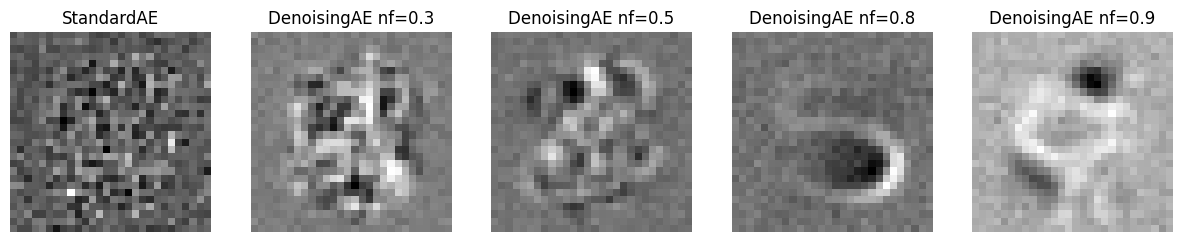

In [ ]:
##VISUALISING ENCODER WEIGHTS

plt.rcParams["figure.figsize"] = (15,6)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.imshow(model_hid256.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax1.set_title('StandardAE')
ax1.axis("off")

ax2.imshow(model_4_a.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax2.set_title('DenoisingAE nf=0.3')
ax2.axis("off")

ax3.imshow(model_4_b.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax3.set_title('DenoisingAE nf=0.5')
ax3.axis("off")

ax4.imshow(model_4_c.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax4.set_title('DenoisingAE nf=0.8')
ax4.axis("off")

ax5.imshow(model_4_d.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax5.set_title('DenoisingAE nf=0.9')
ax5.axis("off")

plt.show()

**Observations:**
- Standard autoencoder when given corrupted input has reconstruction error more than Denoising Autoencoder trained on noise level 0.3.
- Though not very clearly visible but encoder weights of denoising AE have some penstroke detector type visualisation.

#**Manifold Learning**

# Impact of adding random noise to input images

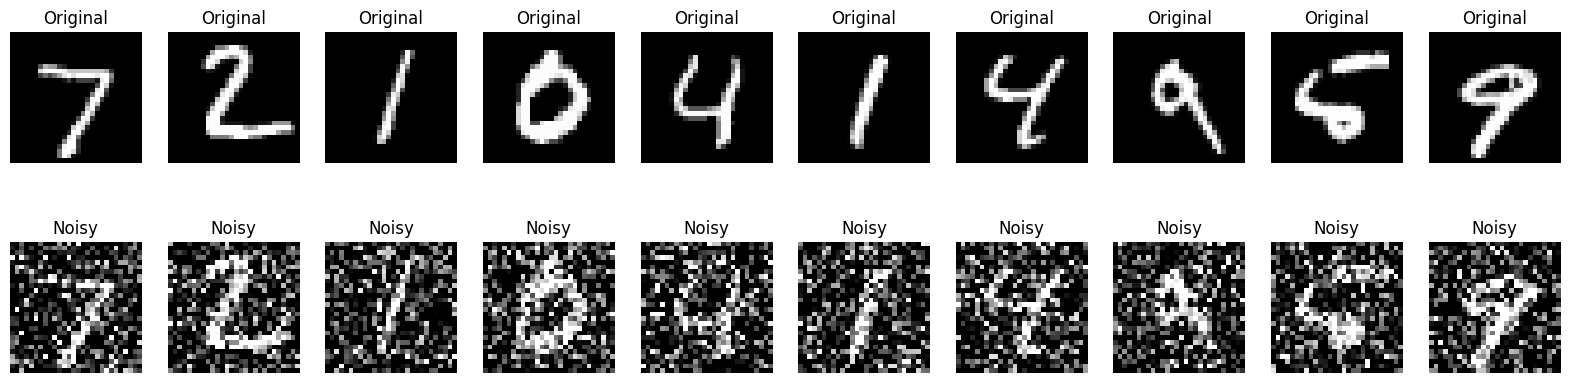

In [8]:
# Function to add random noise to the input images
def add_noise_to_input(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    noisy_images = torch.clip(noisy_images, 0., 1.)  # Ensure pixel values remain in [0, 1]
    return noisy_images

# Get sample images from MNIST test set
sample_images, _ = next(iter(test_loader))
sample_images = sample_images[:10]  # Take the first 10 images
sample_images_flat = sample_images.view(sample_images.size(0), -1)  # Flatten the images to shape (batch_size, 784)

# Add random noise to input images
noisy_images = add_noise_to_input(sample_images_flat)

# Visualize the original and noisy images
plt.figure(figsize=(20, 5))

for i in range(10):  # Loop through the 10 images
    # Plot original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(sample_images[i].view(28, 28).cpu().numpy(), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot noisy image
    plt.subplot(2, 10, i + 11)  # Shift to the next row
    plt.imshow(noisy_images[i].view(28, 28).cpu().numpy(), cmap='gray')
    plt.title(f'Noisy')
    plt.axis('off')

plt.show()

#Observation:

- Random noise disrupts the structured patterns that represent digits.

- The high-dimensional input space for MNIST (784 dimensions) requires specific arrangements of pixels to represent valid digits, and random changes break this structure, making it unlikely that the resulting noisy image still represents a valid digit.

- The noise introduces high-contrast pixels, increasing visual complexity and blurring the boundaries between the digits and the background, which challenges the isolation of original digit features.

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 8),  # Bottleneck
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 784),
            nn.Sigmoid()  # Using Sigmoid to match output range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [10]:
# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
criterion =nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.view(images.size(0), -1)  # Flatten the images
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.0559
Epoch [2/10], Loss: 0.0509
Epoch [3/10], Loss: 0.0491
Epoch [4/10], Loss: 0.0410
Epoch [5/10], Loss: 0.0376
Epoch [6/10], Loss: 0.0386
Epoch [7/10], Loss: 0.0349
Epoch [8/10], Loss: 0.0333
Epoch [9/10], Loss: 0.0351
Epoch [10/10], Loss: 0.0344


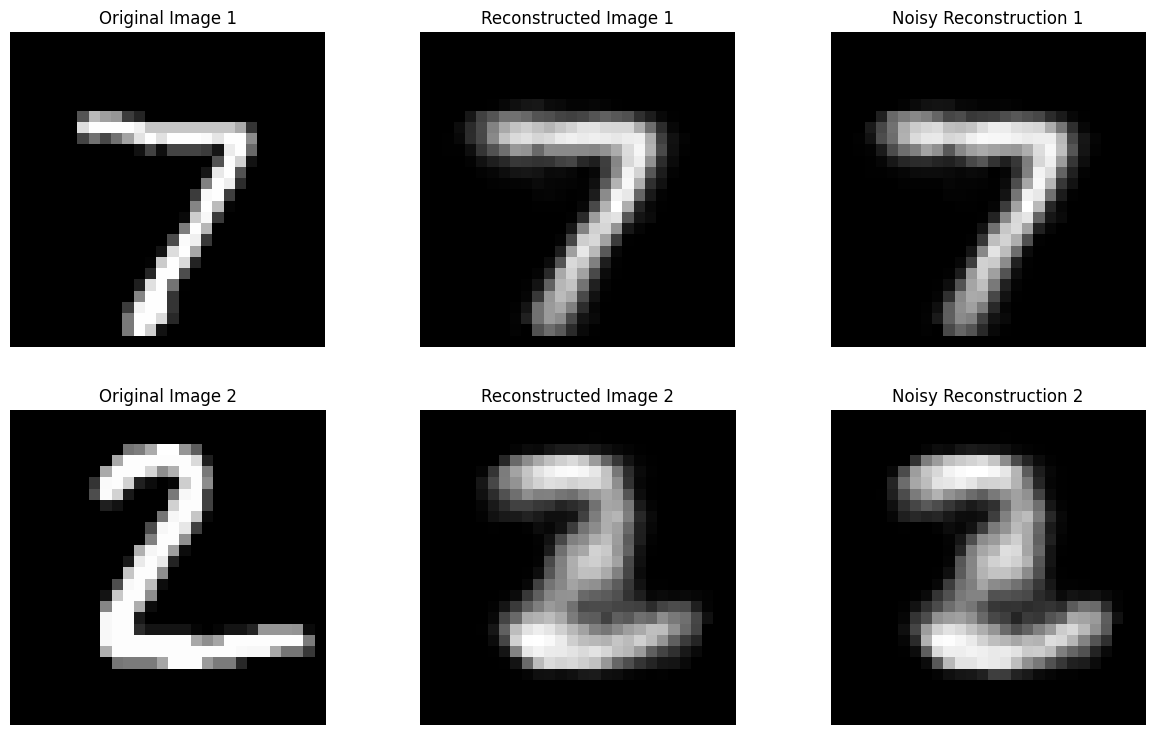

In [11]:
# Function to add noise to the representation
def add_noise(representation, noise_factor=0.5):
    noise = torch.randn_like(representation) * noise_factor
    return representation + noise

# Get two sample images from the test set after the model has converged
sample_images, _ = next(iter(test_loader))

# Ensure we only use 2 images from the batch
sample_images = sample_images[:2]
sample_images_flat = sample_images.view(2, -1)  # Flatten to shape (2, 784) for MNIST (or adjust for other datasets)

# Pass the sample images through the trained autoencoder
with torch.no_grad():
    original_reconstructions = model(sample_images_flat)  # Forward pass through autoencoder (after convergence)

# Encode the sample images (latent representation)
with torch.no_grad():
    encoded_representations = model.encoder(sample_images_flat)

# Add noise to the latent representation
noisy_representations = add_noise(encoded_representations)

# Decode the noisy representations (reconstruct from noisy latent space)
with torch.no_grad():
    noisy_reconstructions = model.decoder(noisy_representations)

# Visualize the original images, reconstructed images, and noisy reconstructed images
plt.figure(figsize=(15, 9))

for i in range(2):  # Loop through the 2 images
    # Original Image
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Reconstructed Image (without noise)
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(original_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Reconstructed Image {i+1}')
    plt.axis('off')

    # Noisy Reconstructed Image
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(noisy_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Noisy Reconstruction {i+1}')
    plt.axis('off')

plt.show()

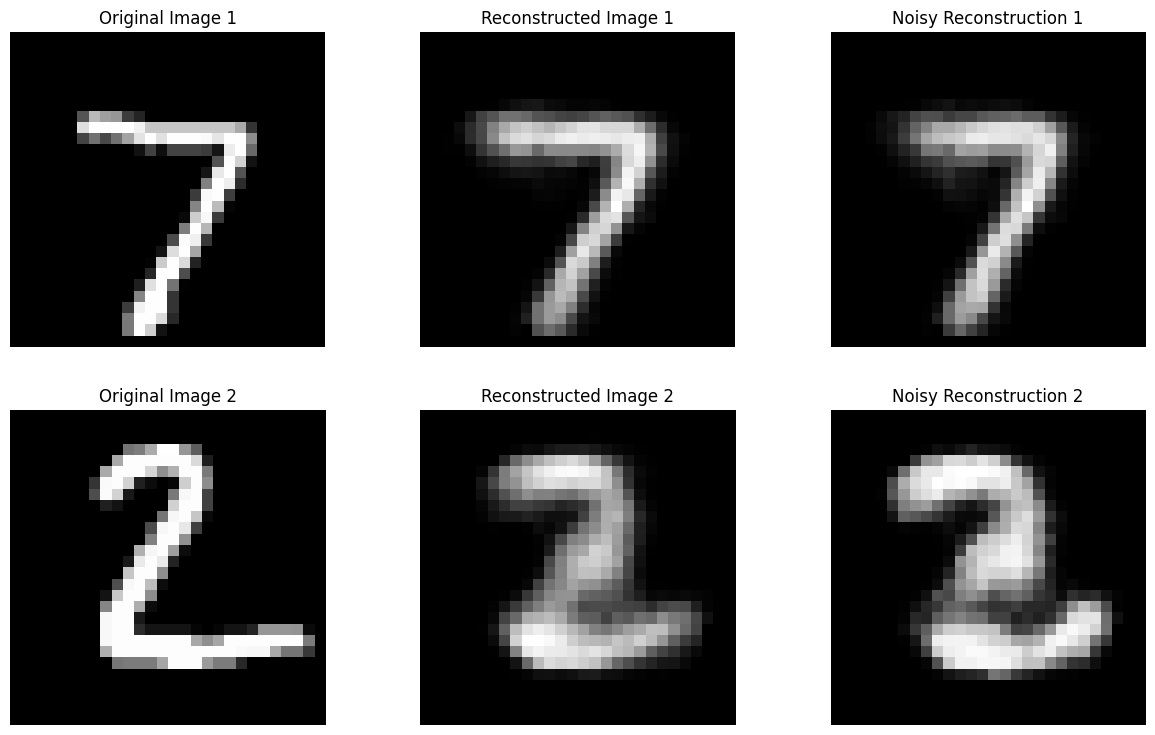

In [12]:
# Function to add noise to the representation
def add_noise(representation, noise_factor=1.0):
    noise = torch.randn_like(representation) * noise_factor
    return representation + noise

# Get two sample images from the test set after the model has converged
sample_images, _ = next(iter(test_loader))

# Ensure we only use 2 images from the batch
sample_images = sample_images[:2]
sample_images_flat = sample_images.view(2, -1)  # Flatten to shape (2, 784) for MNIST (or adjust for other datasets)

# Pass the sample images through the trained autoencoder
with torch.no_grad():
    original_reconstructions = model(sample_images_flat)  # Forward pass through autoencoder (after convergence)

# Encode the sample images (latent representation)
with torch.no_grad():
    encoded_representations = model.encoder(sample_images_flat)

# Add noise to the latent representation
noisy_representations = add_noise(encoded_representations)

# Decode the noisy representations (reconstruct from noisy latent space)
with torch.no_grad():
    noisy_reconstructions = model.decoder(noisy_representations)

# Visualize the original images, reconstructed images, and noisy reconstructed images
plt.figure(figsize=(15, 9))

for i in range(2):  # Loop through the 2 images
    # Original Image
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Reconstructed Image (without noise)
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(original_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Reconstructed Image {i+1}')
    plt.axis('off')

    # Noisy Reconstructed Image
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(noisy_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Noisy Reconstruction {i+1}')
    plt.axis('off')

plt.show()

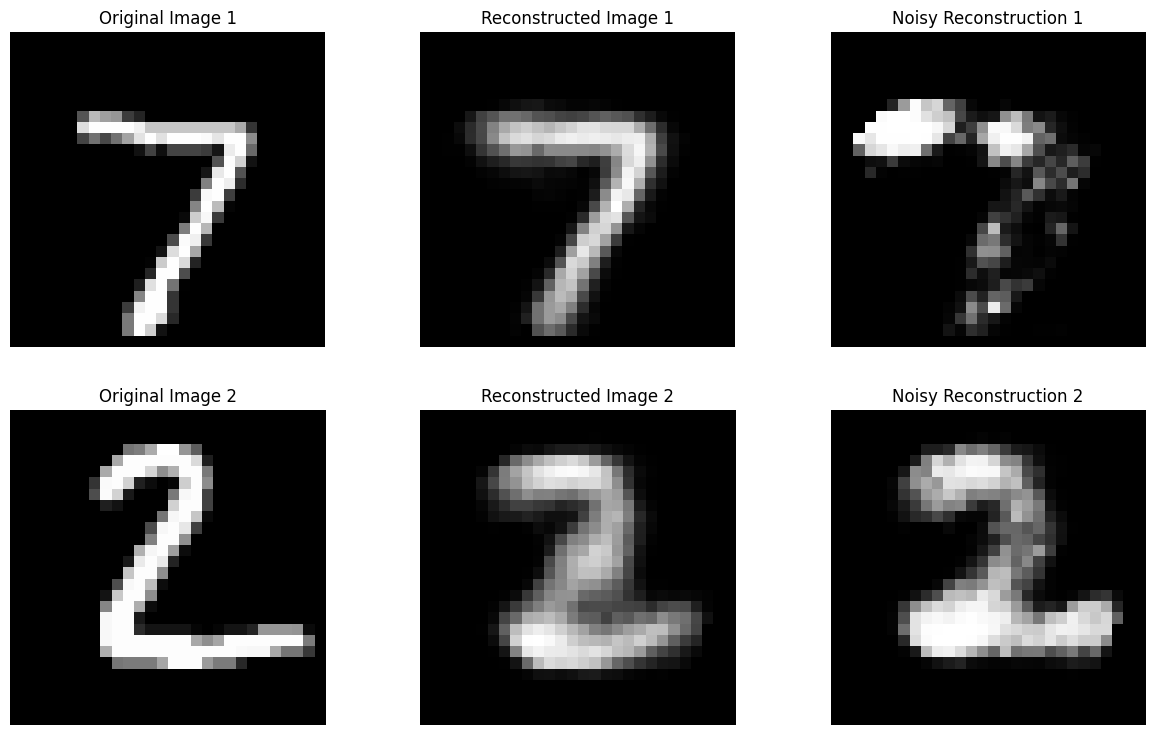

In [13]:
# Function to add noise to the representation
def add_noise(representation, noise_factor=3.0):
    noise = torch.randn_like(representation) * noise_factor
    return representation + noise

# Get two sample images from the test set after the model has converged
sample_images, _ = next(iter(test_loader))

# Ensure we only use 2 images from the batch
sample_images = sample_images[:2]
sample_images_flat = sample_images.view(2, -1)  # Flatten to shape (2, 784) for MNIST (or adjust for other datasets)

# Pass the sample images through the trained autoencoder
with torch.no_grad():
    original_reconstructions = model(sample_images_flat)  # Forward pass through autoencoder (after convergence)

# Encode the sample images (latent representation)
with torch.no_grad():
    encoded_representations = model.encoder(sample_images_flat)

# Add noise to the latent representation
noisy_representations = add_noise(encoded_representations)

# Decode the noisy representations (reconstruct from noisy latent space)
with torch.no_grad():
    noisy_reconstructions = model.decoder(noisy_representations)

# Visualize the original images, reconstructed images, and noisy reconstructed images
plt.figure(figsize=(15, 9))

for i in range(2):  # Loop through the 2 images
    # Original Image
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Reconstructed Image (without noise)
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(original_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Reconstructed Image {i+1}')
    plt.axis('off')

    # Noisy Reconstructed Image
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(noisy_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Noisy Reconstruction {i+1}')
    plt.axis('off')

plt.show()

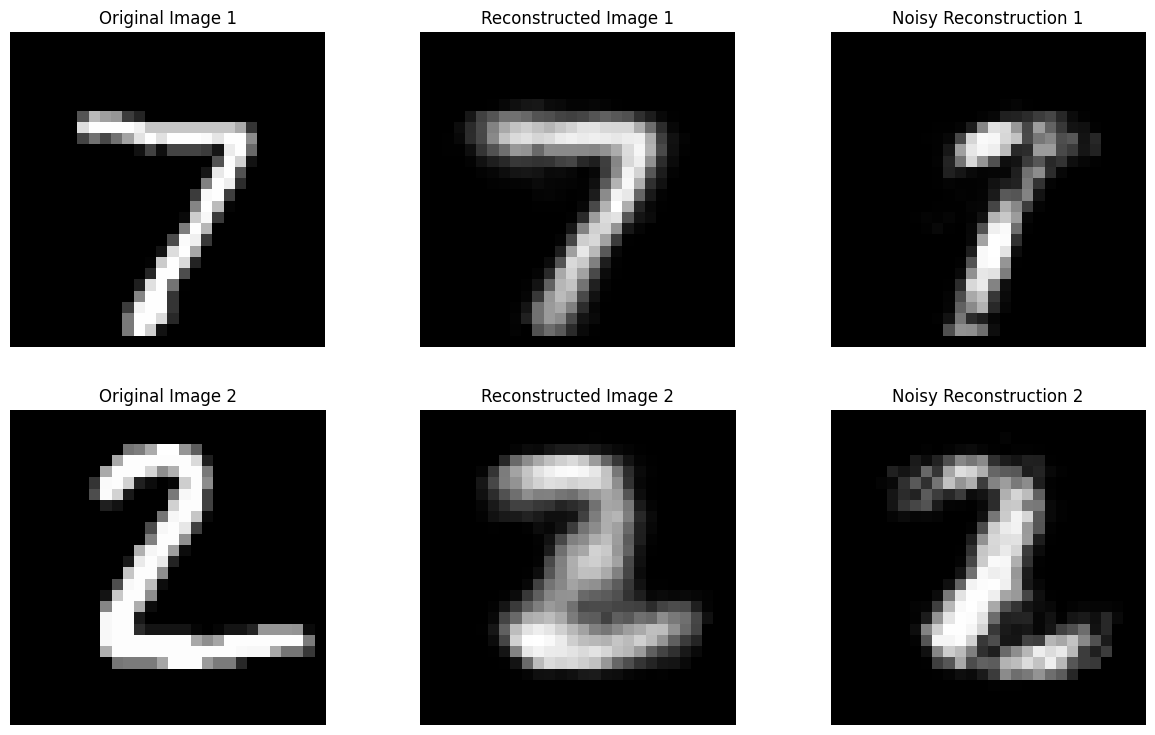

In [14]:
# Function to add noise to the representation
def add_noise(representation, noise_factor=5.0):
    noise = torch.randn_like(representation) * noise_factor
    return representation + noise

# Get two sample images from the test set after the model has converged
sample_images, _ = next(iter(test_loader))

# Ensure we only use 2 images from the batch
sample_images = sample_images[:2]
sample_images_flat = sample_images.view(2, -1)  # Flatten to shape (2, 784) for MNIST (or adjust for other datasets)

# Pass the sample images through the trained autoencoder
with torch.no_grad():
    original_reconstructions = model(sample_images_flat)  # Forward pass through autoencoder (after convergence)

# Encode the sample images (latent representation)
with torch.no_grad():
    encoded_representations = model.encoder(sample_images_flat)

# Add noise to the latent representation
noisy_representations = add_noise(encoded_representations)

# Decode the noisy representations (reconstruct from noisy latent space)
with torch.no_grad():
    noisy_reconstructions = model.decoder(noisy_representations)

# Visualize the original images, reconstructed images, and noisy reconstructed images
plt.figure(figsize=(15, 9))

for i in range(2):  # Loop through the 2 images
    # Original Image
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Reconstructed Image (without noise)
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(original_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Reconstructed Image {i+1}')
    plt.axis('off')

    # Noisy Reconstructed Image
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(noisy_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Noisy Reconstruction {i+1}')
    plt.axis('off')

plt.show()

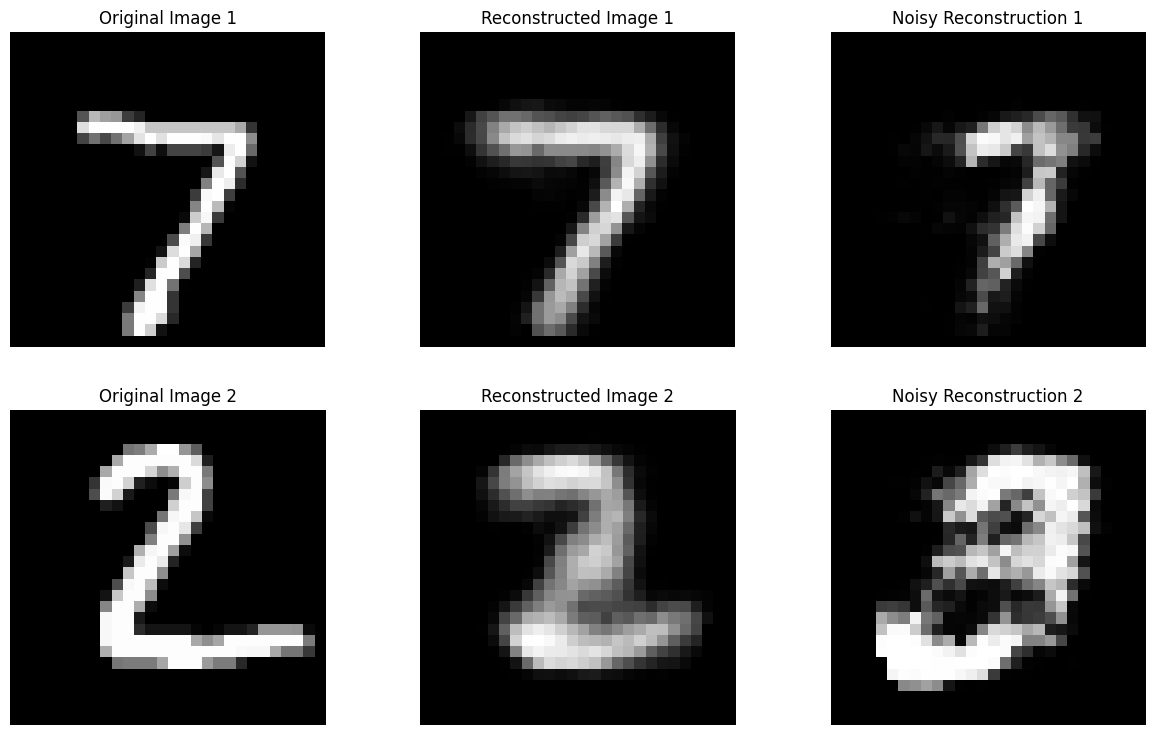

In [18]:
# Function to add noise to the representation
def add_noise(representation, noise_factor=7.0):
    noise = torch.randn_like(representation) * noise_factor
    return representation + noise

# Get two sample images from the test set after the model has converged
sample_images, _ = next(iter(test_loader))

# Ensure we only use 2 images from the batch
sample_images = sample_images[:2]
sample_images_flat = sample_images.view(2, -1)  # Flatten to shape (2, 784) for MNIST (or adjust for other datasets)

# Pass the sample images through the trained autoencoder
with torch.no_grad():
    original_reconstructions = model(sample_images_flat)  # Forward pass through autoencoder (after convergence)

# Encode the sample images (latent representation)
with torch.no_grad():
    encoded_representations = model.encoder(sample_images_flat)

# Add noise to the latent representation
noisy_representations = add_noise(encoded_representations)

# Decode the noisy representations (reconstruct from noisy latent space)
with torch.no_grad():
    noisy_reconstructions = model.decoder(noisy_representations)

# Visualize the original images, reconstructed images, and noisy reconstructed images
plt.figure(figsize=(15, 9))

for i in range(2):  # Loop through the 2 images
    # Original Image
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Reconstructed Image (without noise)
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(original_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Reconstructed Image {i+1}')
    plt.axis('off')

    # Noisy Reconstructed Image
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(noisy_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Noisy Reconstruction {i+1}')
    plt.axis('off')

plt.show()

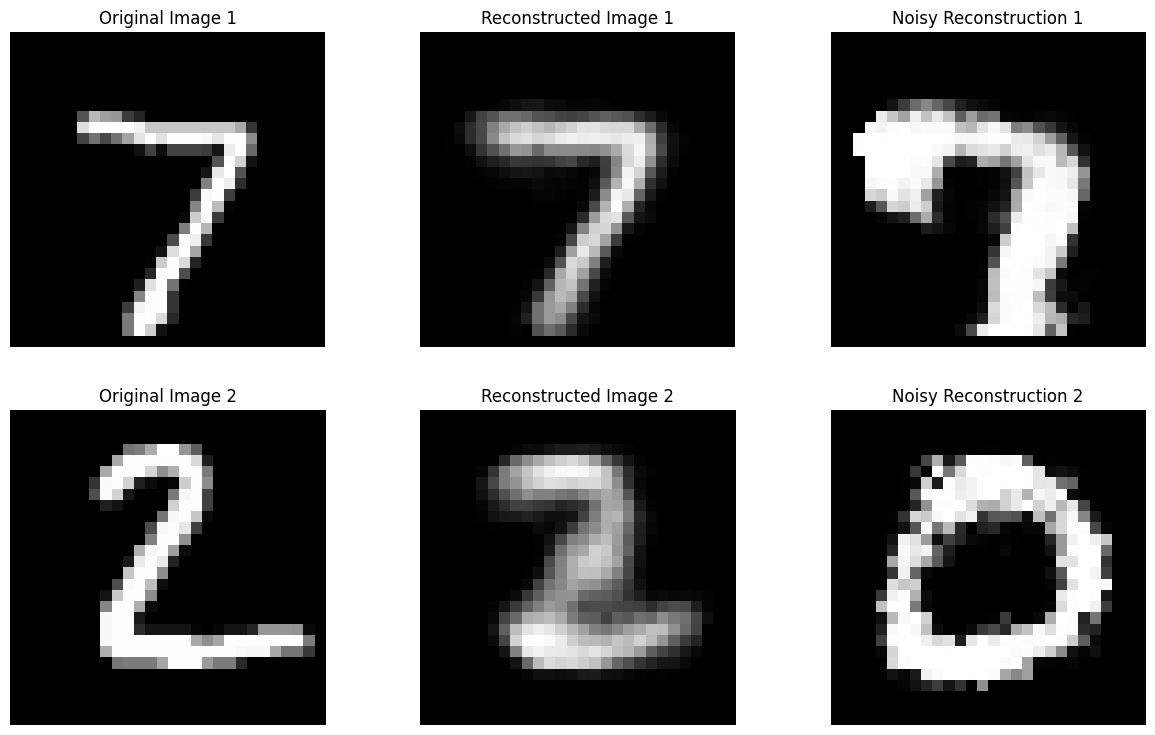

In [24]:
# Function to add noise to the representation
def add_noise(representation, noise_factor=10.0):
    noise = torch.randn_like(representation) * noise_factor
    return representation + noise

# Get two sample images from the test set after the model has converged
sample_images, _ = next(iter(test_loader))

# Ensure we only use 2 images from the batch
sample_images = sample_images[:2]
sample_images_flat = sample_images.view(2, -1)  # Flatten to shape (2, 784) for MNIST (or adjust for other datasets)

# Pass the sample images through the trained autoencoder
with torch.no_grad():
    original_reconstructions = model(sample_images_flat)  # Forward pass through autoencoder (after convergence)

# Encode the sample images (latent representation)
with torch.no_grad():
    encoded_representations = model.encoder(sample_images_flat)

# Add noise to the latent representation
noisy_representations = add_noise(encoded_representations)

# Decode the noisy representations (reconstruct from noisy latent space)
with torch.no_grad():
    noisy_reconstructions = model.decoder(noisy_representations)

# Visualize the original images, reconstructed images, and noisy reconstructed images
plt.figure(figsize=(15, 9))

for i in range(2):  # Loop through the 2 images
    # Original Image
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Reconstructed Image (without noise)
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(original_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Reconstructed Image {i+1}')
    plt.axis('off')

    # Noisy Reconstructed Image
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(noisy_reconstructions[i].view(28, 28).squeeze(), cmap='gray')
    plt.title(f'Noisy Reconstruction {i+1}')
    plt.axis('off')

plt.show()

#Observations:

- As the noise level increases, the quality of the reconstructed images deteriorates significantly. At lower noise levels (0.5-2.0), the autoencoder manages to reconstruct recognizable digits. However, beyond a noise level of 5.0, the reconstructions become increasingly distorted and less identifiable.

- Higher noise levels result in a more pronounced loss of detail in the reconstructed images. For instance, at a noise level of 5.0, some features, such as edges and curves of digits, become blurred, while at noise levels above 7.0, the digits appear almost as random patterns, making it difficult to discern the original digit.

- With higher noise levels (around 8.0-10.0), the outputs exhibit significant variability despite being generated from similar latent representations. This suggests that the autoencoder struggles to map the noisy latent space back to a coherent output, leading to a broader range of reconstruction outcomes that do not correspond to the original inputs.

#**Convolutional Autoencoders**

In [ ]:
class AE5_ConvAE_with_unpooling(nn.Module): #define unpooling outside the decoder and separately in forward nn.Sequential just takes one input

    def __init__(self): #class constructor
        super(AE5_ConvAE_with_unpooling,self).__init__() #calls the parent constructor

        #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        ) # 28x28x1 to 14x14x8
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        ) #14x14x8 to 7x7x16
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        ) #7x7x16 to 3x3x16

        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.Identity()) #7x7x16 to 7x7x16
        self.decoder_conv2 = nn.Sequential(
            nn.Conv2d(16,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU()
        ) #14x14x16 to 14x14x8
        self.decoder_conv3 = nn.Sequential(
            nn.Conv2d(8,1, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU()
        ) #28x28x8 to 28x28x1

        #defining the unpooling operation
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))


    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop

        encoded_input,indices1  = self.encoder_conv1(x.float())  # 28x28x1 to 14x14x8
        encoded_input,indices2  = self.encoder_conv2(encoded_input) #14x14x8 to 7x7x16
        encoded_input,indices3  = self.encoder_conv3(encoded_input) #7x7x16 to 3x3x16

        reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7])) #3x3x16 to 7x7x16
        reconstructed_input     = self.decoder_conv1(reconstructed_input) #7x7x16 to 7x7x16
        reconstructed_input     = self.unpool(reconstructed_input,indices2) #7x7x16 to 14x14x16
        reconstructed_input     = self.decoder_conv2(reconstructed_input)#14x14x16 to 14x14x8
        reconstructed_input     = self.unpool(reconstructed_input,indices1)#14x14x8 to 28x28x8
        reconstructed_input     = self.decoder_conv3(reconstructed_input)#28x28x8 to 28x28x1

        return reconstructed_input,encoded_input

In [ ]:
model_5_a = AE5_ConvAE_with_unpooling()
criterion_5_a = nn.MSELoss()
optimizer_5_a = torch.optim.Adam(model_5_a.parameters(),lr=0.001)

training_loss_5_a=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    outputs,_=model_5_a(images)
    loss=criterion_5_a(outputs,images)
    training_loss_5_a.append(loss.item())

    optimizer_5_a.zero_grad()
    loss.backward()
    optimizer_5_a.step()

  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [ ]:
class AE5_ConvAE_with_deconv(nn.Module):
    def __init__(self):
        super(AE5_ConvAE_with_deconv,self).__init__()

        #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )

        #decoder module
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),
            nn.ReLU()
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU()
        )

    def forward(self,x):

        encoded_input  = self.encoder_conv1(x.float())
        encoded_input  = self.encoder_conv2(encoded_input)
        encoded_input  = self.encoder_conv3(encoded_input)

        reconstructed_input = self.decoder_conv1(encoded_input)
        reconstructed_input = self.decoder_conv2(reconstructed_input)
        reconstructed_input = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input

In [ ]:
model_5_b = AE5_ConvAE_with_deconv()
criterion_5_b = nn.MSELoss()
optimizer_5_b = torch.optim.Adam(model_5_b.parameters(),lr=0.001)

training_loss_5_b=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    outputs,_=model_5_b(images)
    loss=criterion_5_b(outputs,images)
    training_loss_5_b.append(loss.item())

    optimizer_5_b.zero_grad()
    loss.backward()
    optimizer_5_b.step()

  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")




Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [ ]:
class AE5_ConvAE_with_deconv_unpool(nn.Module):
    def __init__(self):
        super(AE5_ConvAE_with_deconv_unpool,self).__init__()

         #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )

        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )

        #unpooling
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))

    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop

        encoded_input,indices1  = self.encoder_conv1(x.float())
        encoded_input,indices2  = self.encoder_conv2(encoded_input)
        encoded_input,indices3  = self.encoder_conv3(encoded_input)

        reconstructed_input = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7]))
        reconstructed_input = self.decoder_conv1(reconstructed_input)
        reconstructed_input = self.unpool(reconstructed_input,indices2)
        reconstructed_input = self.decoder_conv2(reconstructed_input)
        reconstructed_input = self.unpool(reconstructed_input,indices1)
        reconstructed_input = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input


In [ ]:
model_5_c = AE5_ConvAE_with_deconv_unpool()
criterion_5_c = nn.MSELoss()
optimizer_5_c = torch.optim.Adam(model_5_c.parameters(),lr=0.001)

training_loss_5_c=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    outputs,_=model_5_c(images)
    loss=criterion_5_c(outputs,images)
    training_loss_5_c.append(loss.item())

    optimizer_5_c.zero_grad()
    loss.backward()
    optimizer_5_c.step()

  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")


Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


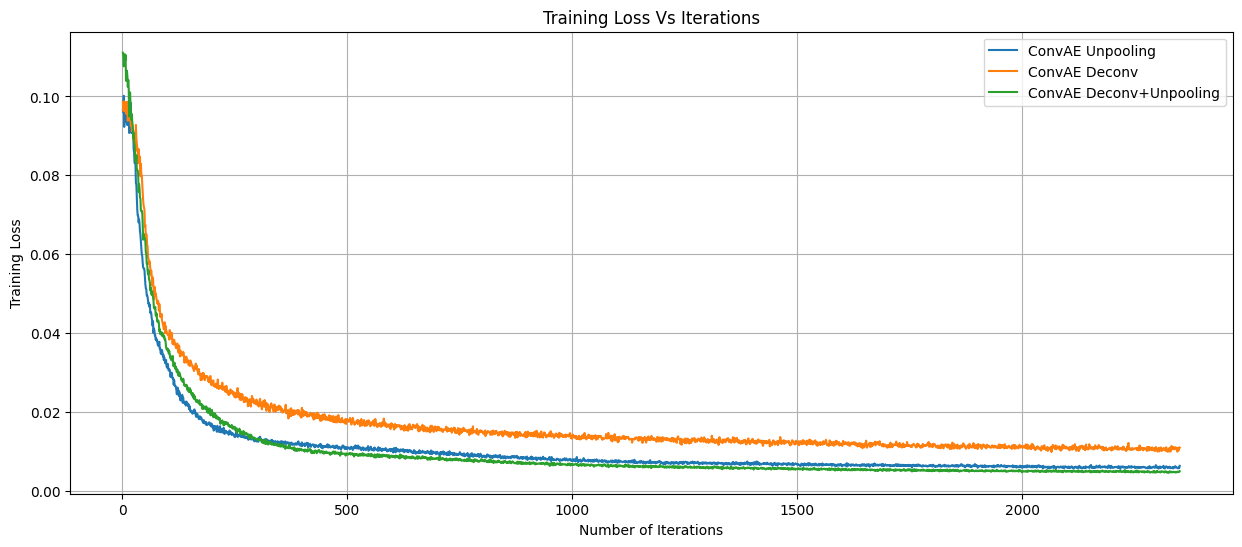

In [ ]:
plt.plot(range(1,len(training_loss_5_a)+1),training_loss_5_a,label="ConvAE Unpooling")
plt.plot(range(1,len(training_loss_5_a)+1),training_loss_5_b,label="ConvAE Deconv")
plt.plot(range(1,len(training_loss_5_a)+1),training_loss_5_c,label="ConvAE Deconv+Unpooling")
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()

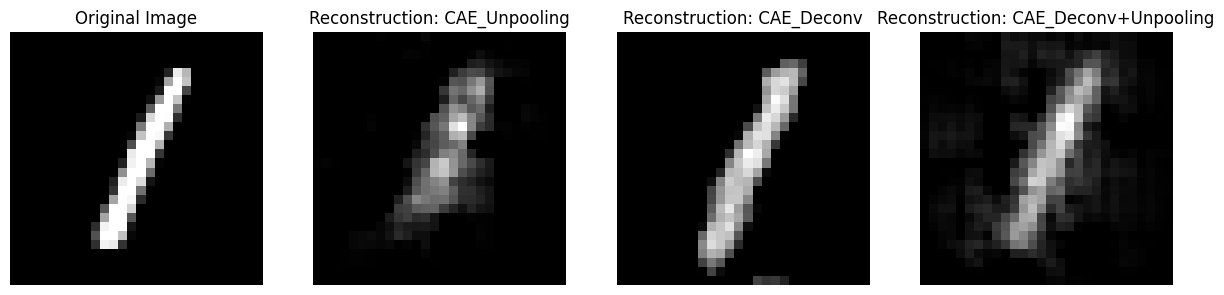

Reconstruction Error in ConvAE Unpooling: 11.234124905335815
Reconstruction Error in ConvAE Deconv: -1.4055003756956699
Reconstruction Error in ConvAE Deconv+Unpooling: -0.3102661686320747
______________________________________________________________________________________________


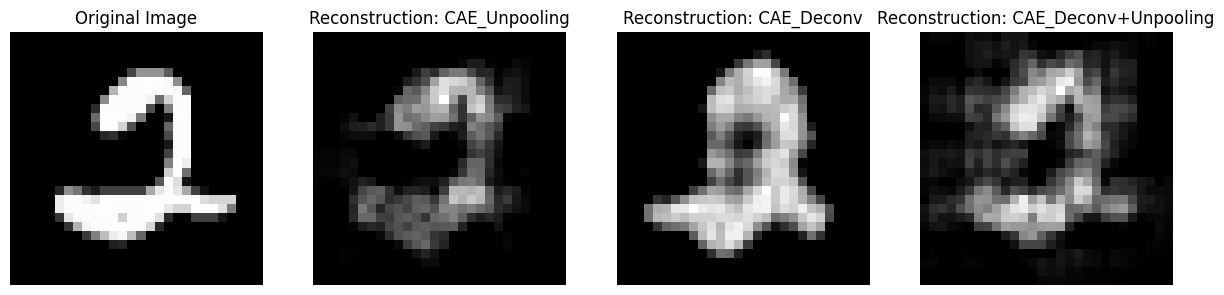

Reconstruction Error in ConvAE Unpooling: 286.5323405489686
Reconstruction Error in ConvAE Deconv: 60.04885587398819
Reconstruction Error in ConvAE Deconv+Unpooling: 85.61746780524234
______________________________________________________________________________________________


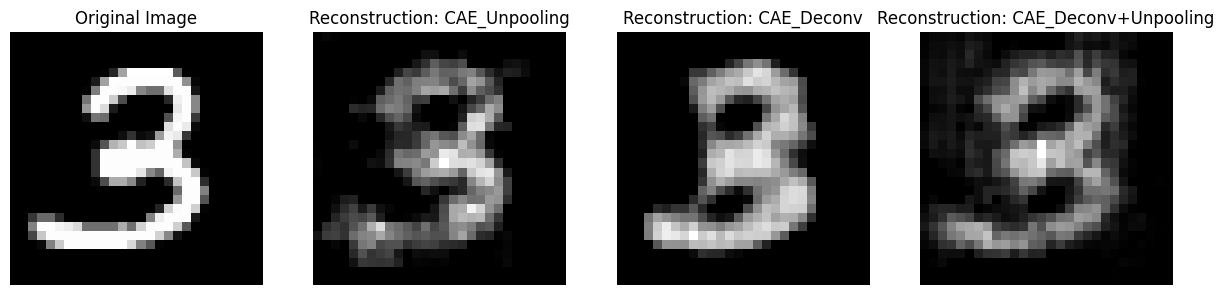

Reconstruction Error in ConvAE Unpooling: 179.24624768836247
Reconstruction Error in ConvAE Deconv: -21.199034076658013
Reconstruction Error in ConvAE Deconv+Unpooling: -16.239284685114132
______________________________________________________________________________________________


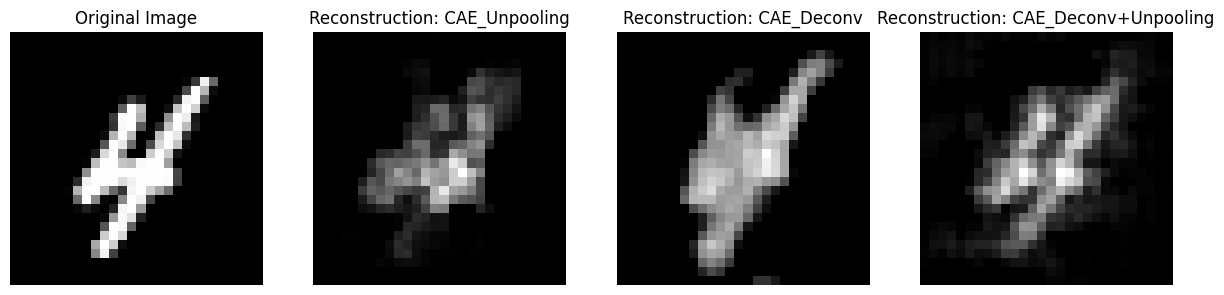

Reconstruction Error in ConvAE Unpooling: 118.51167533133857
Reconstruction Error in ConvAE Deconv: -4.64380432908483
Reconstruction Error in ConvAE Deconv+Unpooling: 15.405881911030578
______________________________________________________________________________________________


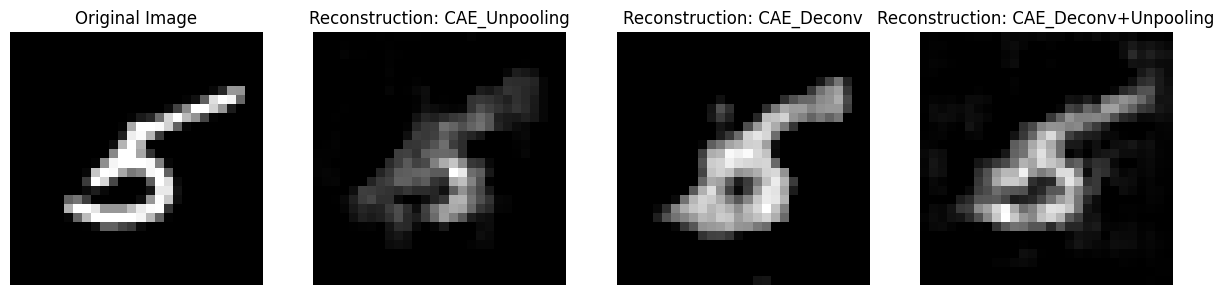

Reconstruction Error in ConvAE Unpooling: 48.152131855358235
Reconstruction Error in ConvAE Deconv: 4.073457362669939
Reconstruction Error in ConvAE Deconv+Unpooling: -3.5883763536256232
______________________________________________________________________________________________


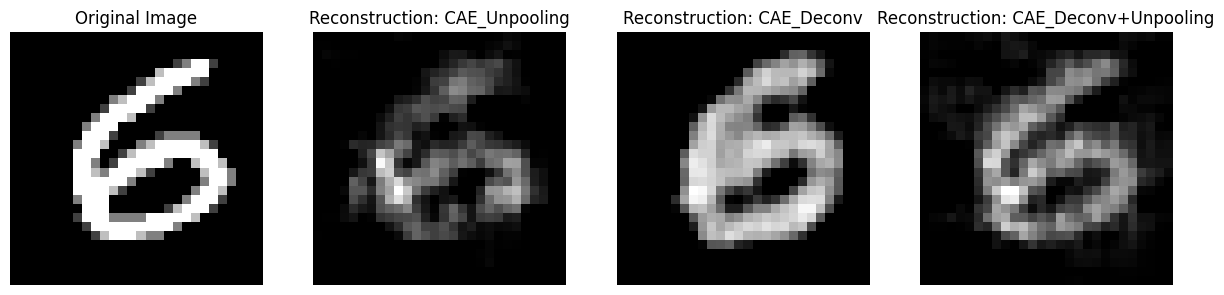

Reconstruction Error in ConvAE Unpooling: 355.24374216010676
Reconstruction Error in ConvAE Deconv: 6.777887878345329
Reconstruction Error in ConvAE Deconv+Unpooling: 68.2292085601378
______________________________________________________________________________________________


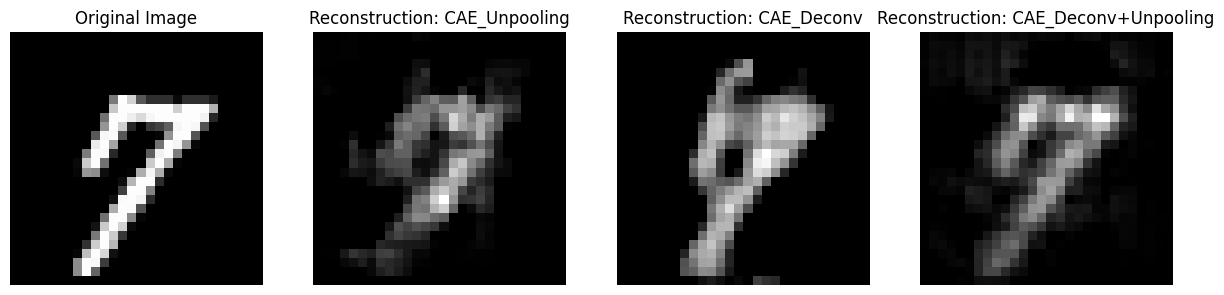

Reconstruction Error in ConvAE Unpooling: 139.41802261812475
Reconstruction Error in ConvAE Deconv: 21.94462291790176
Reconstruction Error in ConvAE Deconv+Unpooling: 24.037594039694973
______________________________________________________________________________________________


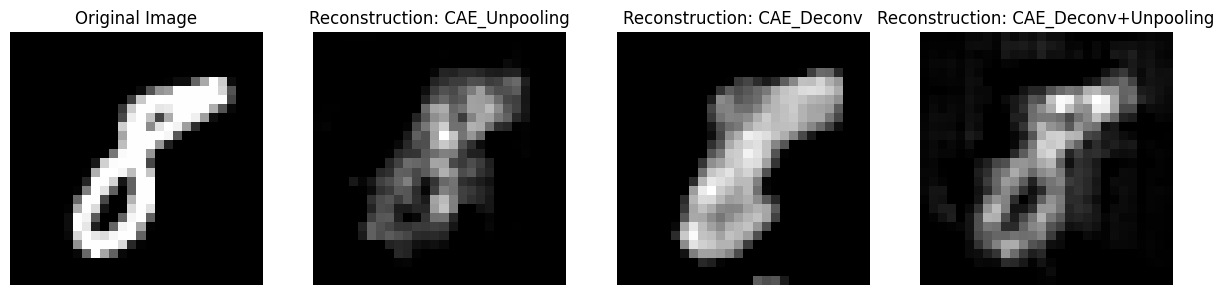

Reconstruction Error in ConvAE Unpooling: 162.28777739301745
Reconstruction Error in ConvAE Deconv: 6.38876997719619
Reconstruction Error in ConvAE Deconv+Unpooling: 38.435406576058824
______________________________________________________________________________________________


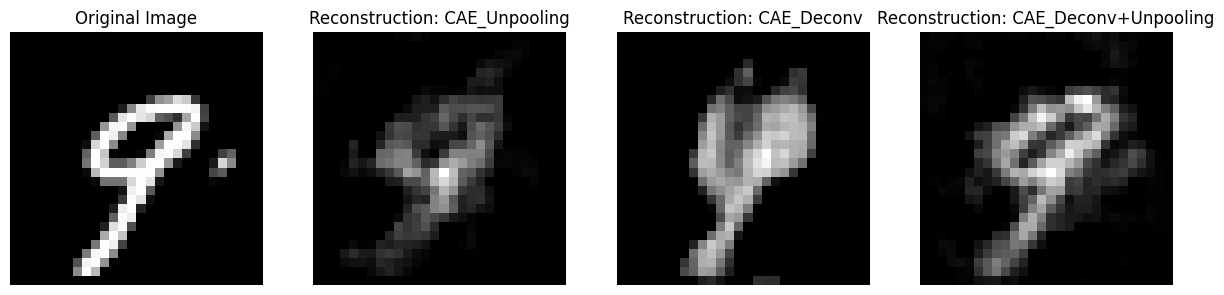

Reconstruction Error in ConvAE Unpooling: 114.93306803095905
Reconstruction Error in ConvAE Deconv: 2.440420379285225
Reconstruction Error in ConvAE Deconv+Unpooling: 15.064461754653077
______________________________________________________________________________________________


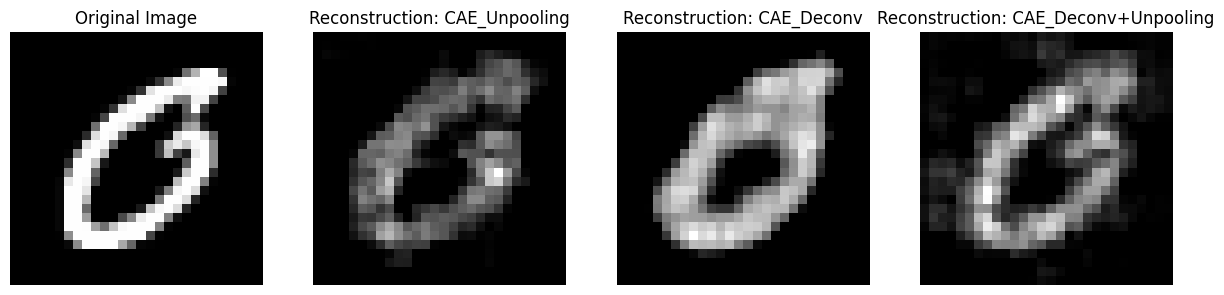

Reconstruction Error in ConvAE Unpooling: 261.43499223541403
Reconstruction Error in ConvAE Deconv: 17.66976994109564
Reconstruction Error in ConvAE Deconv+Unpooling: 52.62210097727178
______________________________________________________________________________________________


In [ ]:

model_5_a.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images=images.reshape(10,1,28,28)
    outputs_5_a,_ = model_5_a(images.float())


model_5_b.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images=images.reshape(10,1,28,28)
    outputs_5_b,_ = model_5_b(images.float())


activation_5_c=[]
model_5_c.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images=images.reshape(10,1,28,28)
    outputs_5_c,_= model_5_c(images.float())


plt.rcParams["figure.figsize"] = (15,6)

for i in range(10):
  fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_5_a[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('Reconstruction: CAE_Unpooling')
  ax2.axis("off")

  ax3.imshow(outputs_5_b[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('Reconstruction: CAE_Deconv')
  ax3.axis("off")

  ax4.imshow(outputs_5_c[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('Reconstruction: CAE_Deconv+Unpooling')
  ax4.axis("off")

  plt.show()

  print("Reconstruction Error in ConvAE Unpooling:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs_5_a[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_5_a[i].detach().numpy()/255)).T)))
  print("Reconstruction Error in ConvAE Deconv:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs_5_b[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_5_b[i].detach().numpy()/255)).T)))
  print("Reconstruction Error in ConvAE Deconv+Unpooling:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs_5_c[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_5_c[i].detach().numpy()/255)).T)))
  print("______________________________________________________________________________________________")


In [ ]:
model_5_a.encoder_conv1[0].weight.detach().numpy().squeeze().shape

(8, 3, 3)

In [ ]:
#Function for visualisation of weights
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
  n,c,w,h = tensor.shape

  if allkernels: tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

  rows = np.min((tensor.shape[0] // nrow + 1, 64))
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

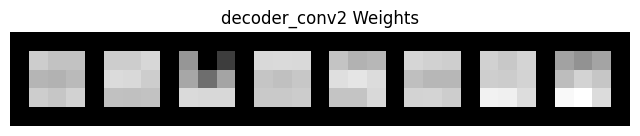

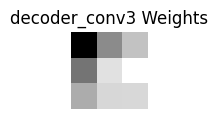

In [ ]:
#VISUALISING DECODER WEIGHTS FOR CONVOLUTION AUTOENCODER WITH UNPOOLING

filter = model_5_a.decoder_conv2[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()

filter = model_5_a.decoder_conv3[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

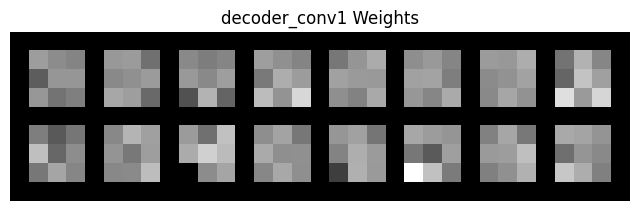

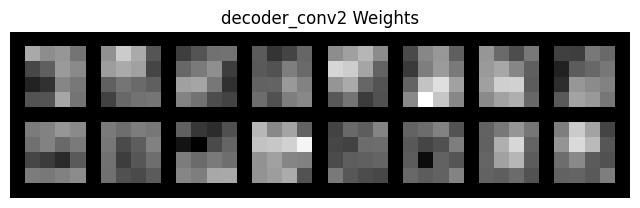

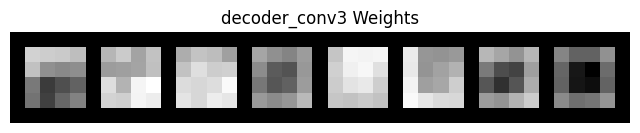

In [ ]:
#VISUALISING DECODER WEIGHTS FOR CONVOLUTION AUTOENCODER WITH DECONVOLUTION

filter = model_5_b.decoder_conv1[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv1 Weights')
plt.show()

filter = model_5_b.decoder_conv2[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()

filter = model_5_b.decoder_conv3[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

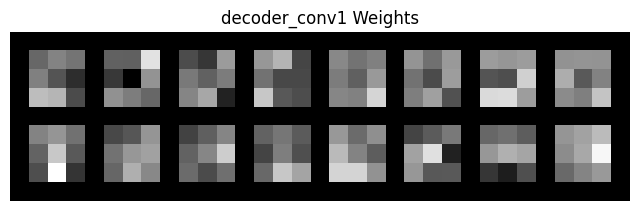

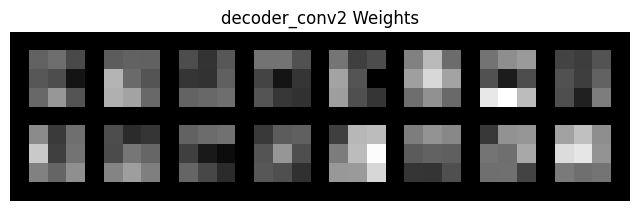

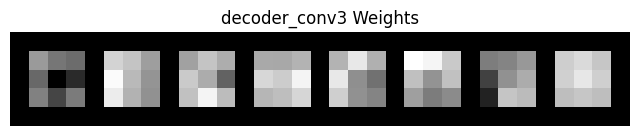

In [ ]:
#VISUALISING DECODER WEIGHTS FOR CONVOLUTION AUTOENCODER WITH DECONVOLUTION+UNPOOLING

filter = model_5_c.decoder_conv1[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv1 Weights')
plt.show()

filter = model_5_c.decoder_conv2[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()

filter = model_5_c.decoder_conv3[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

**Observations:**
- Decoder weights of Deconvolution with Unpooling and Unpooling are smaller than the only Deconvolution one. This can be because, Unpooling handles part of the upsampling, reducing the need for the deconvolution layers to learn complex upsampling transformations.
- By looking at reconstruction error, it looks like unpooling and deconv+ unpooling does better on reconstruction of images.
- Visually, reconstructed images using Deconvolution are appealing.